# Housing Data Workflow Notebook

Modular workflow where you can run individual steps independently.
Run cells in order or skip any steps you don't need.

Each step shows dataframe views and statistics for inspection.

## Quick Start
- Run **Setup** cell first
- Then run any combination of Step 1-4 cells
- Skip cells you don't want to execute
- Each cell is self-contained and shows results

## 🔧 Setup

Run this cell first to import modules and define helper functions.

In [1]:
import sys
from pathlib import Path
from typing import Optional

import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

# Add current directory to path for local imports
sys.path.append(".")

# Import our workflow modules
from fetch_affordable_housing_data import update_local_data, verify_and_fetch_hpd_data, verify_and_fetch_hpd_projects_data
from query_dob_filings import query_dob_bisweb_bin, query_dob_bisweb_bbl, query_dobnow_bin, query_dobnow_bbl, decompose_bbl, query_condo_lots_for_bbl, query_dob_for_condo_bbls, get_all_condo_related_bbls, query_dob_by_address, pad_block, pad_lot
from query_co_filings import query_co_api, DOB_NOW_CO_URL, DOB_CO_URL

print("✅ All imports successful")

# Helper functions
def _normalize_bin(bin_value) -> Optional[str]:
    """Normalize BIN to a clean string."""
    if pd.isna(bin_value):
        return None
    try:
        return str(int(float(bin_value)))
    except (TypeError, ValueError):
        value = str(bin_value).strip()
        return value or None

def _extract_bins_from_df(df: pd.DataFrame) -> list[str]:
    """Extract BINs from a DataFrame and return as a list for CO searches."""
    candidate_cols = []
    for col in df.columns:
        if col.lower() in ("bin", "bin_normalized"):
            candidate_cols.append(col)
    if not candidate_cols:
        raise SystemExit(f"Could not find a BIN column in DataFrame")

    bins = []
    for val in df[candidate_cols[0]].dropna():
        normalized = _normalize_bin(val)
        if normalized:
            bins.append(normalized)
    
    # Remove duplicates using set, then sort
    unique_bins = set()
    for b in bins:
        if b:
            unique_bins.add(b)
    return sorted(unique_bins)

def _query_co_filings_from_bins_and_bbls(bin_list: list[str], bbl_list: list[str] = None, output_path: Path = None) -> pd.DataFrame:
    """Query CO filings using a list of BINs and BBLs (no file needed)."""
    # Convert BINs to integers for API query
    bin_ints = []
    for bin_str in bin_list:
        if str(bin_str).isdigit():
            bin_ints.append(int(bin_str))
    bins = sorted(list(set(bin_ints)))
    
    # Query DOB NOW Certificate of Occupancy API
    print("=" * 70)
    print("QUERYING DOB NOW CERTIFICATE OF OCCUPANCY")
    print("=" * 70)
    dob_now_co = query_co_api(DOB_NOW_CO_URL, bins, bin_column="bin")
    
    # Query DOB Certificate Of Occupancy API
    print("\n" + "=" * 70)
    print("QUERYING DOB CERTIFICATE OF OCCUPANCY")
    print("=" * 70)
    dob_co = query_co_api(DOB_CO_URL, bins, bin_column="bin_number")
    
    # Query by BBL for records not found by BIN
    dob_now_co_bbl = pd.DataFrame()
    dob_co_bbl = pd.DataFrame()
    
    if bbl_list and len(bbl_list) > 0:
        # Convert BBLs to integers for API query
        bbl_ints = []
        for bbl_str in bbl_list:
            if str(bbl_str).isdigit():
                bbl_ints.append(int(bbl_str))
        bbls = sorted(list(set(bbl_ints)))
        
        if len(bbls) > 0:
            # Query DOB NOW CO by BBL
            print("\n" + "=" * 70)
            print("QUERYING DOB NOW CERTIFICATE OF OCCUPANCY BY BBL")
            print("=" * 70)
            dob_now_co_bbl = query_co_api(DOB_NOW_CO_URL, bbls, bin_column="bbl")
            
            # Query DOB CO by BBL
            print("\n" + "=" * 70)
            print("QUERYING DOB CERTIFICATE OF OCCUPANCY BY BBL")
            print("=" * 70)
            dob_co_bbl = query_co_api(DOB_CO_URL, bbls, bin_column="bbl")
            
            # Add source and normalize columns
            if not dob_now_co_bbl.empty:
                print(f"\nDOB NOW CO Filings (by BBL): {len(dob_now_co_bbl)} records")
                dob_now_co_bbl['source'] = 'DOB_NOW_CO_BBL'
                if 'bbl' in dob_now_co_bbl.columns:
                    dob_now_co_bbl['bbl_normalized'] = dob_now_co_bbl['bbl'].astype(str).str.zfill(10)
            
            if not dob_co_bbl.empty:
                print(f"\nDOB CO Filings (by BBL): {len(dob_co_bbl)} records")
                dob_co_bbl['source'] = 'DOB_CO_BBL'
                if 'bbl' in dob_co_bbl.columns:
                    dob_co_bbl['bbl_normalized'] = dob_co_bbl['bbl'].astype(str).str.zfill(10)
    
    # Combine results
    print("\n" + "=" * 70)
    print("SUMMARY")
    print("=" * 70)
    
    if not dob_now_co.empty:
        print(f"\nDOB NOW CO Filings: {len(dob_now_co)} records")
        dob_now_co['source'] = 'DOB_NOW_CO'
        if 'bin' in dob_now_co.columns:
            dob_now_co['bin_normalized'] = dob_now_co['bin'].astype(str)
    
    if not dob_co.empty:
        print(f"\nDOB CO Filings: {len(dob_co)} records")
        dob_co['source'] = 'DOB_CO'
        if 'bin_number' in dob_co.columns:
            dob_co['bin_normalized'] = dob_co['bin_number'].astype(str)
    
    # Combine all dataframes (BIN and BBL results)
    dfs_to_combine = []
    if not dob_now_co.empty:
        dfs_to_combine.append(dob_now_co)
    if not dob_co.empty:
        dfs_to_combine.append(dob_co)
    if not dob_now_co_bbl.empty:
        dfs_to_combine.append(dob_now_co_bbl)
    if not dob_co_bbl.empty:
        dfs_to_combine.append(dob_co_bbl)
    
    if len(dfs_to_combine) >= 2:
        all_cols = list(set([col for df in dfs_to_combine for col in df.columns]))
        if 'bin_normalized' not in all_cols:
            all_cols.append('bin_normalized')
        if 'source' not in all_cols:
            all_cols.append('source')
        dob_now_co_aligned = dob_now_co.reindex(columns=all_cols)
        dob_co_aligned = dob_co.reindex(columns=all_cols)
        combined = pd.concat([dob_now_co_aligned, dob_co_aligned], ignore_index=True)
    elif not dob_now_co.empty:
        combined = dob_now_co.copy()
    elif not dob_co.empty:
        combined = dob_co.copy()
    else:
        print("\nNo CO filings found in either API")
        return pd.DataFrame()
    
    print(f"\nTotal combined records: {len(combined)}")
    
    return combined

print("✅ Helper functions defined")

✅ All imports successful
✅ Helper functions defined


## 📥 Step 1: Fetch HPD Data

Load or refresh the HPD affordable housing dataset.

**Options:**
- Set `refresh_data = True` to fetch fresh data
- Set `refresh_data = False` to use existing data

In [2]:
# Step 1 Configuration
refresh_data = True  # Set to True to fetch fresh HPD data
hpd_output_path = "data/raw/Affordable_Housing_Production_by_Building.csv"  # Output path for HPD data
refresh_hpd_projects = False  # Set to True to fetch fresh HPD projects data

print("=" * 70)
print("STEP 1: FETCH HPD DATA")
print("=" * 70)

# Start quality tracking

# Handle HPD projects cache refresh if requested
if refresh_hpd_projects:
    print("Force refreshing HPD projects cache...")
    hpd_projects_df, hpd_projects_path = verify_and_fetch_hpd_projects_data(use_existing=False)
    print(f"HPD projects cache refreshed: {len(hpd_projects_df)} records\n")

if refresh_data:
    print("Fetching fresh HPD data from NYC Open Data...")
    hpd_df, hpd_csv = update_local_data(hpd_output_path)
else:
    print("Verifying local HPD data against API...")
    hpd_df, hpd_csv = verify_and_fetch_hpd_data(output_path=hpd_output_path, use_projects_cache=not refresh_hpd_projects)

if not hpd_csv.exists():
    raise SystemExit(f"HPD dataset not found at {hpd_csv}")

# Get total units before filter
original_count = len(hpd_df)
original_units = hpd_df['Total Units'].sum()

# Filter to New Construction only
hpd_new_construction_df = hpd_df[hpd_df["Reporting Construction Type"] == "New Construction"].copy()

# Filter out confidential projects
confidential_mask = hpd_new_construction_df['Project Name'].str.contains('confidential', case=False, na=False)
confidential_count = confidential_mask.sum()
hpd_new_construction_df = hpd_new_construction_df[~confidential_mask]

filtered_count = len(hpd_new_construction_df)
filtered_units = hpd_new_construction_df['Total Units'].sum()
filtered_out = original_count - filtered_count
filtered_units_out = original_units - filtered_units

print(f"🏗️ Filtered to New Construction only (excluding {confidential_count} confidential projects):")
print(f"  Original: {original_count:,} projects, {original_units:,} total units")
print(f"  Filtered: {filtered_count:,} projects ({filtered_count/original_count*100:.1f}%), {filtered_units:,} total units ({filtered_units/original_units*100:.1f}%)")
print(f"  Removed: {filtered_out:,} non-new construction projects ({filtered_out/original_count*100:.1f}%), {filtered_units_out:,} units filtered out ({filtered_units_out/original_units*100:.1f}%)")

print(f"✅ Step 1 complete: {len(hpd_new_construction_df):,} records loaded")
print(f"📁 Data location: {hpd_csv}")

# Display the dataframe
print("\n🔍 HPD Dataset Overview (New Construction only):")
print(f"Shape: {hpd_new_construction_df.shape}")
print("\nColumns:")
for col in hpd_new_construction_df.columns:
    print(f"  - {col}")

print("\n📊 Sample Data:")
display(hpd_new_construction_df.head())
print("\n📈 Basic Statistics:")
display(hpd_new_construction_df.describe(include="all"))

STEP 1: FETCH HPD DATA
Fetching fresh HPD data from NYC Open Data...
Created backup: data/raw/Affordable_Housing_Production_by_Building.csv.backup_20251204_114954
Fetching affordable housing data from NYC Open Data API...
Endpoint: https://data.cityofnewyork.us/resource/hg8x-zxpr.json
Fetching records 1-1000...
  Retrieved 1000 records (total: 1,000)
Fetching records 1001-2000...
  Retrieved 1000 records (total: 2,000)
Fetching records 2001-3000...
  Retrieved 1000 records (total: 3,000)
Fetching records 3001-4000...
  Retrieved 1000 records (total: 4,000)
Fetching records 4001-5000...
  Retrieved 1000 records (total: 5,000)
Fetching records 5001-6000...
  Retrieved 1000 records (total: 6,000)
Fetching records 6001-7000...
  Retrieved 1000 records (total: 7,000)
Fetching records 7001-8000...
  Retrieved 1000 records (total: 8,000)
Fetching records 8001-9000...
  Retrieved 604 records (total: 8,604)
Fetching records 8605-9604...

Completed! Retrieved 8,604 total records

Enriching build

,Project ID,Project Name,Project Start Date,Building ID,Number,Street,Borough,Postcode,BBL,BIN,...,6-BR+ Units,Unknown-BR Units,Counted Rental Units,Counted Homeownership Units,All Counted Units,Total Units,Program Group,Project Completion Date,Extended Affordability Status,Planned Tax Benefit
0,44218,MEC E. 125TH ST. PARCEL B WEST,2018-12-31T00:00:00.000,987329,2319,3 AVENUE,Manhattan,10035,1017907501,1054682,...,NaN,NaN,297.0,NaN,297.0,404,Multifamily Finance Program,2022-02-16T00:00:00.000,No,Article XI
1,44223,ROCHESTER SUYDAM PHASE 1,2021-06-30T00:00:00.000,927737,335,RALPH AVENUE,Brooklyn,11233,3015560003,3000000,...,NaN,NaN,NaN,13.0,13.0,13,Multifamily Finance Program,2024-09-24T00:00:00.000,No,Article XI
2,44223,ROCHESTER SUYDAM PHASE 1,2021-06-30T00:00:00.000,969695,35,ROCHESTER AVENUE,Brooklyn,11233,3017090009,3000000,...,NaN,NaN,NaN,8.0,8.0,8,Multifamily Finance Program,2024-09-24T00:00:00.000,No,Article XI
3,44223,ROCHESTER SUYDAM PHASE 1,2021-06-30T00:00:00.000,975702,18-22,SUYDAM PLACE,Brooklyn,11233,3017090028,3000000,...,NaN,NaN,NaN,15.0,15.0,15,Multifamily Finance Program,2024-09-24T00:00:00.000,No,Article XI
4,44223,ROCHESTER SUYDAM PHASE 1,2021-06-30T00:00:00.000,977564,329,RALPH AVENUE,Brooklyn,11233,3015560007,3000000,...,NaN,NaN,NaN,10.0,10.0,10,Multifamily Finance Program,2024-09-24T00:00:00.000,No,Article XI



📈 Basic Statistics:


,Project ID,Project Name,Project Start Date,Building ID,Number,Street,Borough,Postcode,BBL,BIN,...,6-BR+ Units,Unknown-BR Units,Counted Rental Units,Counted Homeownership Units,All Counted Units,Total Units,Program Group,Project Completion Date,Extended Affordability Status,Planned Tax Benefit
count,3184,3184,3184,3184,3184,3184,3184,3182,3115,3115,...,0.0,10.000000,3024.000000,249.000000,3174.000000,3184.00000,3184,2266,3184,3111
unique,2717,2717,1429,3162,1964,1047,5,146,3007,2397,...,NaN,NaN,NaN,NaN,NaN,NaN,3,918,2,8
top,53017,Nehemiah Spring Creek Homes at Gateway Estates 4A,2016-06-27T00:00:00.000,975696,61,SCHROEDERS AVENUE,Brooklyn,11239,2035150020,3000000,...,NaN,NaN,NaN,NaN,NaN,NaN,Multifamily Incentives Program,2019-05-28T00:00:00.000,No,421a
freq,83,83,83,2,11,70,1650,165,9,331,...,NaN,NaN,NaN,NaN,NaN,NaN,2412,83,3182,2332
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.300000,37.614749,4.277108,36.172653,68.42745,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22.735435,67.433412,8.856354,66.178105,119.07109,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,1.000000,1.000000,1.000000,1.00000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,3.000000,1.000000,3.000000,9.00000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,9.000000,1.000000,9.000000,23.00000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,37.000000,4.000000,34.750000,75.00000,NaN,NaN,NaN,NaN


In [3]:
# How many unique counts are there by project id as primary key per program group,
# and show total units in parentheticals (but NOT for the unique project counts).

# Compute total units per Program Group (all rows)
units_per_group = hpd_new_construction_df.groupby('Program Group')['Total Units'].sum()

print("Program Group counts (raw rows) (total units in parentheses):")
raw_row_counts = hpd_new_construction_df['Program Group'].value_counts()
for group, count in raw_row_counts.items():
    units = units_per_group.get(group, 0)
    print(f"{group}: {count} rows ({units} units)")
print()

# Group by Program Group, count unique Project IDs
unique_proj_counts = hpd_new_construction_df.groupby('Program Group')['Project ID'].nunique().sort_values(ascending=False)
unique_proj_ids = (
    hpd_new_construction_df
    .groupby('Program Group')
    .apply(lambda df: df['Project ID'].unique())
)

print("Program Group counts (unique Project ID as primary key):")
for group, count in unique_proj_counts.items():
    print(f"{group}: {count} projects")
print()

print("\nTax Abatement by Program Group (based on unique Project ID):")
if 'Planned Tax Benefit' in hpd_new_construction_df.columns:
    # For this, deduplicate by Project ID first
    unique_project_rows = hpd_new_construction_df.drop_duplicates(subset=['Project ID'])
    tax_abate_ct = (
        unique_project_rows
        .groupby('Program Group')['Planned Tax Benefit']
        .value_counts(dropna=False)
        .unstack(fill_value=0)
        .sort_index(axis=1)
    )
    # Also display total units per Program Group in this table, if desired
    units_per_group_project = unique_project_rows.groupby('Program Group')['Total Units'].sum()
    print("Total units (unique Project ID per Program Group):")
    display(units_per_group_project)
    display(tax_abate_ct)
else:
    print("Column 'Planned Tax Benefit' not found in dataset.")

# Make a version of this with unit count by program and tax benefit
if 'Planned Tax Benefit' in unique_project_rows.columns and 'Program Group' in unique_project_rows.columns:
    units_pivot = (
        unique_project_rows
        .groupby(['Program Group', 'Planned Tax Benefit'])['Total Units']
        .sum()
        .unstack(fill_value=0)
        .sort_index(axis=1)
    )
    print("Total units by Program Group and Planned Tax Benefit (unique Project ID only):")
    display(units_pivot)
else:
    print("Required columns not found for unit pivot table.")

# Calculate average units per year by Program Group and Planned Tax Benefit

if 'Project Start Date' in unique_project_rows.columns and 'Total Units' in unique_project_rows.columns:
    # Extract year from 'Project Start Date'
    unique_project_rows = unique_project_rows.copy()
    unique_project_rows['Project Year'] = pd.to_datetime(unique_project_rows['Project Start Date'], errors='coerce').dt.year

    avg_units_per_year = (
        unique_project_rows
        .groupby(['Program Group', 'Planned Tax Benefit', 'Project Year'])['Total Units']
        .sum()
        .reset_index()
    )

    # Now calculate the average units per year by program group and tax abatement
    avg_units_table = (
        avg_units_per_year
        .groupby(['Program Group', 'Planned Tax Benefit'])['Total Units']
        .mean()
        .unstack(fill_value=0)
        .sort_index(axis=1)
    )
    print("Average units per year by Program Group and Planned Tax Benefit (unique Project ID only):")
    display(avg_units_table)
else:
    print("Required columns not found for average units per year table.")



Program Group counts (raw rows) (total units in parentheses):
Multifamily Incentives Program: 2412 rows (152021 units)
Multifamily Finance Program: 576 rows (64396 units)
Small Homes Program: 196 rows (1456 units)

Program Group counts (unique Project ID as primary key):
Multifamily Incentives Program: 2304 projects
Multifamily Finance Program: 377 projects
Small Homes Program: 36 projects


Tax Abatement by Program Group (based on unique Project ID):
Total units (unique Project ID per Program Group):


/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_68964/872236451.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df['Project ID'].unique())


Program Group
Multifamily Finance Program        57576
Multifamily Incentives Program    147060
Small Homes Program                  933
Name: Total Units, dtype: int64

Planned Tax Benefit,420a,420c,421a,467-M,485-X,Article IV,Article XI,UDAAP,NaN
Program Group,,,,,,,,,
Multifamily Finance Program,3,253,24,0,0,0,75,2,20
Multifamily Incentives Program,1,30,2205,2,32,0,11,0,23
Small Homes Program,0,14,3,0,0,1,8,6,4


Total units by Program Group and Planned Tax Benefit (unique Project ID only):


Planned Tax Benefit,420a,420c,421a,467-M,485-X,Article IV,Article XI,UDAAP
Program Group,,,,,,,,
Multifamily Finance Program,233,36475,3806,0,0,0,13718,4
Multifamily Incentives Program,318,4271,136252,630,1068,0,449,0
Small Homes Program,0,485,80,0,0,6,229,16


Average units per year by Program Group and Planned Tax Benefit (unique Project ID only):


Planned Tax Benefit,420a,420c,421a,467-M,485-X,Article IV,Article XI,UDAAP
Program Group,,,,,,,,
Multifamily Finance Program,116.5,3039.583333,634.333333,0.0,0.0,0.0,1143.166667,2.0
Multifamily Incentives Program,318.0,388.272727,11354.333333,630.0,534.0,0.0,89.800000,0.0
Small Homes Program,0.0,53.888889,26.666667,0.0,0.0,6.0,38.166667,4.0


/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_68964/2311148772.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', len(tax_benefits))
/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_68964/2311148772.py:121: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles_tax.append(plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black', label=f"{tax_benefits[i]}"))


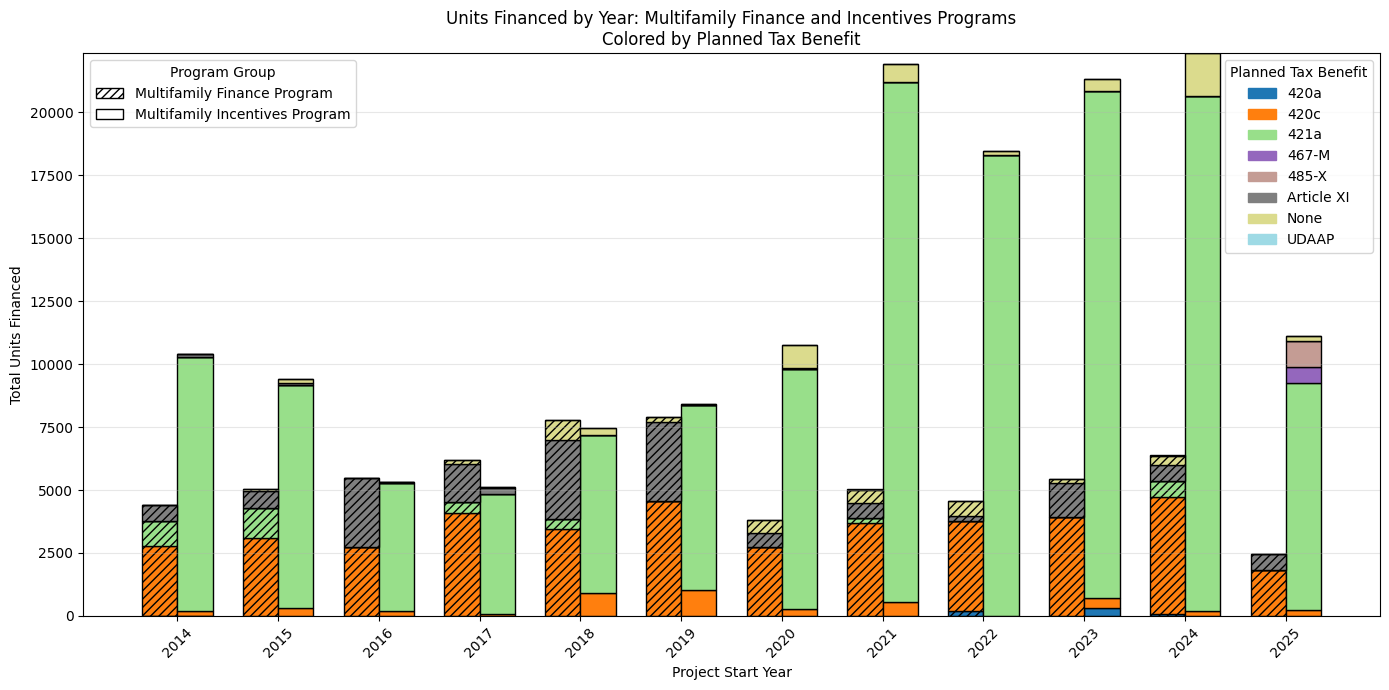

In [4]:
# We'll use the full raw HPD data, because we want all programs, not just Multifamily Finance Program
if 'Project Start Date' in hpd_new_construction_df.columns and 'Total Units' in hpd_new_construction_df.columns:
    hpd_bar_df = hpd_new_construction_df.copy()
    hpd_bar_df['Project Year'] = pd.to_datetime(hpd_bar_df['Project Start Date'], errors='coerce').dt.year

    # Only focus on desired groups
    programs_of_interest = ['Multifamily Finance Program', 'Multifamily Incentives Program']
    mask = hpd_bar_df['Program Group'].isin(programs_of_interest)
    hpd_bar_df = hpd_bar_df[mask & hpd_bar_df['Project Year'].notna()]

    # Fill NAs in Planned Tax Benefit with "None"
    hpd_bar_df['Planned Tax Benefit'] = hpd_bar_df['Planned Tax Benefit'].fillna('None')

    # Prepare for grouped bar with stack
    # Pivot: rows = Project Year, columns = (Program Group, Planned Tax Benefit), values = sum of units
    pivot = (
        hpd_bar_df
        .groupby(['Project Year', 'Program Group', 'Planned Tax Benefit'])['Total Units']
        .sum()
        .reset_index()
    )

    # Ensure proper order of years and programs
    years = sorted(pivot['Project Year'].dropna().unique())
    tax_benefits = sorted(pivot['Planned Tax Benefit'].unique())
    # Keep consistent order for bars
    program_order = ['Multifamily Finance Program', 'Multifamily Incentives Program']

    # Prepare data structure: for each year, for each program, get breakdown by tax benefit
    bar_data = {}
    for year in years:
        bar_data[year] = {}
        for prog in program_order:
            mask = (pivot['Project Year'] == year) & (pivot['Program Group'] == prog)
            year_prog_data = pivot[mask].set_index('Planned Tax Benefit')['Total Units'].reindex(tax_benefits, fill_value=0)
            bar_data[year][prog] = year_prog_data.values

    # Number of bars per group (2 programs), group by year, stacked by tax benefit
    x = range(len(years))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 7))

    # Colors for planned tax benefits
    color_map = cm.get_cmap('tab20', len(tax_benefits))
    colors = []
    for i in range(len(tax_benefits)):
        colors.append(color_map(i))

    bottoms_p1 = [0] * len(years)
    bottoms_p2 = [0] * len(years)

    # For each tax benefit, draw the stack pieces for both programs
    legend_handles = []
    for idx, tax in enumerate(tax_benefits):
        values_p1 = []
        for year in years:
            values_p1.append(bar_data[year][program_order[0]][idx])
        values_p2 = []
        for year in years:
            values_p2.append(bar_data[year][program_order[1]][idx])

        x_positions_p1 = []
        for i in x:
            x_positions_p1.append(i - width/2)
        x_positions_p2 = []
        for i in x:
            x_positions_p2.append(i + width/2)
        
        legend_labels = []
        for h in legend_handles:
            legend_labels.append(h.get_label())
        
        bar1 = ax.bar(
            x_positions_p1, values_p1, width,
            bottom=bottoms_p1, color=colors[idx],
            label=tax if (tax not in legend_labels) else None,
            edgecolor='black', hatch='////'
        )
        bar2 = ax.bar(
            x_positions_p2, values_p2, width,
            bottom=bottoms_p2, color=colors[idx],
            label=None,
            edgecolor='black'
        )

        legend_labels = []
        for h in legend_handles:
            legend_labels.append(h.get_label())
        if tax not in legend_labels:
            legend_handles.append(bar1)

        new_bottoms_p1 = []
        for b, v in zip(bottoms_p1, values_p1):
            new_bottoms_p1.append(b + v)
        bottoms_p1 = new_bottoms_p1
        
        new_bottoms_p2 = []
        for b, v in zip(bottoms_p2, values_p2):
            new_bottoms_p2.append(b + v)
        bottoms_p2 = new_bottoms_p2

    # Add year labels
    ax.set_xticks(x)
    year_labels = []
    for y in years:
        year_labels.append(str(int(y)))
    ax.set_xticklabels(year_labels, rotation=45)
    ax.set_xlabel("Project Start Year")
    ax.set_ylabel("Total Units Financed")
    ax.set_title("Units Financed by Year: Multifamily Finance and Incentives Programs\nColored by Planned Tax Benefit")

    # Custom legend for program groups
    progs = [
        mpatches.Patch(color='gray', label='Multifamily Finance Program', ec='black', hatch='////'),
        mpatches.Patch(color='gray', label='Multifamily Incentives Program', ec='black')
    ]
    # Only add one legend for planned tax benefit
    handles_tax = []
    for i in range(len(tax_benefits)):
        handles_tax.append(plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black', label=f"{tax_benefits[i]}"))
    legend1 = ax.legend(handles=handles_tax, title="Planned Tax Benefit", loc='upper right')
    ax.add_artist(legend1)
    # Add manual tick legend for program bars
    bar_locs = [x[0] - width/2, x[0] + width/2]
    ax.bar(bar_locs[0], 0, width, color='white', hatch='////', ec='black', label='Multifamily Finance Program')
    ax.bar(bar_locs[1], 0, width, color='white', ec='black', label='Multifamily Incentives Program')
    ax.legend(
        handles=[
            plt.Rectangle((0,0),1,1, facecolor='white', hatch='////', edgecolor='black', label='Multifamily Finance Program'),
            plt.Rectangle((0,0),1,1, facecolor='white', edgecolor='black', label='Multifamily Incentives Program')
        ], title="Program Group", loc='upper left'
    )

    ax.grid(True, which='major', axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Required columns ('Project Start Date', 'Total Units') not found in HPD Data.")



In [5]:
# Count and sample: Planned Tax Benefit '421a' and Project Start Date in 2025
if "Planned Tax Benefit" in hpd_new_construction_df.columns and "Project Start Date" in hpd_new_construction_df.columns:
    # Filter for 421a and 2025 start year
    mask_421a_2025 = (
        (hpd_new_construction_df["Planned Tax Benefit"] == "421a") &
        (hpd_new_construction_df["Project Start Date"].astype(str).str.startswith("2025"))
    )
    hpd_421a_2025_df = hpd_new_construction_df[mask_421a_2025]

    # Count unique projects (by Project ID), and total units
    total_projects = hpd_421a_2025_df["Project ID"].nunique() if "Project ID" in hpd_421a_2025_df.columns else len(hpd_421a_2025_df)
    total_units = hpd_421a_2025_df["Total Units"].sum() if "Total Units" in hpd_421a_2025_df.columns else "N/A"

    print(f"Total projects with Planned Tax Benefit '421a' and 2025 Start Date: {total_projects:,}")
    print(f"Total units in these projects: {total_units:,}")

    # Show up to 5 sample rows
    pd.set_option('display.max_columns', None)
    print("\nSample 421a Planned Tax Benefit projects with Project Start Date in 2025:")
    display(hpd_421a_2025_df)
    pd.reset_option('display.max_columns')
else:
    print("One or both of the columns 'Planned Tax Benefit' or 'Project Start Date' not found in HPD DataFrame.")



Total projects with Planned Tax Benefit '421a' and 2025 Start Date: 136
Total units in these projects: 9,024

Sample 421a Planned Tax Benefit projects with Project Start Date in 2025:


,Project ID,Project Name,Project Start Date,Building ID,Number,Street,Borough,Postcode,BBL,BIN,Community Board,Council District,Census Tract,NTA - Neighborhood Tabulation Area,Latitude,Longitude,Latitude (Internal),Longitude (Internal),Building Completion Date,Reporting Construction Type,Extended Affordability Only,Prevailing Wage Status,Extremely Low Income Units,Very Low Income Units,Low Income Units,Moderate Income Units,Middle Income Units,Other Income Units,Studio Units,1-BR Units,2-BR Units,3-BR Units,4-BR Units,5-BR Units,6-BR+ Units,Unknown-BR Units,Counted Rental Units,Counted Homeownership Units,All Counted Units,Total Units,Program Group,Project Completion Date,Extended Affordability Status,Planned Tax Benefit
5478,70212,534 3RD AVENUE,2025-02-11T00:00:00.000,996025,534,3 AVENUE,Manhattan,10016,1008910044,1000000,MN-06,4,80,MN0603,40.74676,-73.977383,40.746941,-73.977628,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,7.0,NaN,NaN,NaN,3.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,7.0,160,Multifamily Incentives Program,NaN,No,421a
7215,74187,3051 ATLANTIC AVENUE,2025-06-12T00:00:00.000,1017563,3051,ATLANTIC AVENUE,Brooklyn,11208,3039570053,3336148,BK-05,37,1168,BK0501,40.678703,-73.882074,40.678942,-73.882297,NaN,New Construction,No,Non Prevailing Wage,NaN,5.0,5.0,3.0,NaN,NaN,2.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,13.0,49,Multifamily Incentives Program,NaN,No,421a
7669,75052,4-34 26TH AVENUE,2025-06-18T00:00:00.000,1017588,1934-04-01T00:00:00.000,26 AVENUE,Queens,11102,4009090035,4000000,QN-01,22,87,QN0102,40.776048,-73.932284,40.775449,-73.931577,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,26.0,NaN,6.0,NaN,8.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,32.0,NaN,32.0,138,Multifamily Incentives Program,NaN,No,421a
7670,75053,4-42 26TH AVENUE,2025-06-18T00:00:00.000,1017589,1942-04-01T00:00:00.000,26 AVENUE,Queens,11102,4009080012,4020640,QN-01,22,87,QN0102,40.776048,-73.93228,40.775171,-73.931122,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,19.0,NaN,3.0,NaN,4.0,7.0,11.0,NaN,NaN,NaN,NaN,NaN,22.0,NaN,22.0,108,Multifamily Incentives Program,NaN,No,421a
7671,75056,8-11 26TH AVENUE,2025-06-18T00:00:00.000,1017586,2025-08-11T00:00:00.000,26 AVENUE,Queens,11102,4009060001,4000000,QN-01,22,91,QN0102,40.77561,-73.9308,40.776033,-73.93028,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,34.0,NaN,8.0,NaN,23.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,42.0,186,Multifamily Incentives Program,NaN,No,421a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8579,77141,600 CROWN STREET,2025-05-02T00:00:00.000,872511,600,CROWN STREET,Brooklyn,11213,3014170008,3000000,BK-09,35,333,BK0901,40.665607,-73.938452,40.665272,-73.938113,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,NaN,NaN,30.0,NaN,NaN,12.0,18.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,30.0,100,Multifamily Incentives Program,NaN,No,421a
8580,77142,1054 41 STREET,2025-05-01T00:00:00.000,148901,1054,41 STREET,Brooklyn,11219,3055910027,3000000,BK-12,38,112,BK1201,40.642801,-73.992934,40.642526,-73.992919,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,NaN,NaN,9.0,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,9.0,28,Multifamily Incentives Program,NaN,No,421a
8581,77143,21-07 ASTORIA BLVD APARTMENTS,2025-04-25T00:00:00.000,979882,21-07,ASTORIA BOULEVARD,Queens,11102,4008840057,4000000,QN-01,22,69,QN0103,40.772138,-73.92563,40.772294,-73.925388,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,NaN,NaN,21.0,NaN,3.0,7.0,11.0,NaN,NaN,NaN,NaN,NaN,21.0,NaN,21.0,68,Multifamily Incentives Program,NaN,No,421a
8582,77144,1229 EASTERN PARKWAY,2025-04-23T00:00:00.000,1017561,1229,EASTERN PARKWAY,Brooklyn,11213,3013920073,3000000,BK-08,41,35701,BK0802,40.668609,-73.927454,40.669057,-73.927443,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,NaN,NaN,17.0,NaN,NaN,12.0,5.0,NaN,NaN,NaN,NaN,NaN,17.0,NaN,17.0,54,Multifamily Incentives Program,NaN,No,421a


In [6]:
# Filter to Multifamily Finance Program (already filtered to New Construction in Step 1)
original_count = len(hpd_new_construction_df)
print(f"Using HPD data from Step 1: {original_count:,} total buildings (New Construction)")

# Apply filters: Multifamily Finance Program (already filtered to New Construction in Step 1)
hpd_multifamily_finance_new_construction_df = hpd_new_construction_df[
    hpd_new_construction_df["Program Group"] == "Multifamily Finance Program"
].copy()
filtered_count = len(hpd_multifamily_finance_new_construction_df)

print(f"🏗️ Filtered to Multifamily Finance Program:")
print(f"  Original: {original_count:,} buildings (New Construction)")
print(f"  Filtered: {filtered_count:,} buildings ({filtered_count/original_count*100:.1f}%)")
print(f"📁 Created critical DataFrame in memory: {filtered_count:,} Multifamily Finance Program (New Construction) buildings")


Using HPD data from Step 1: 3,184 total buildings (New Construction)
🏗️ Filtered to Multifamily Finance Program:
  Original: 3,184 buildings (New Construction)
  Filtered: 576 buildings (18.1%)
📁 Created critical DataFrame in memory: 576 Multifamily Finance Program (New Construction) buildings


## 🏗️ Step 3: Query DOB Filings

Search for DOB New Building filings.


In [7]:
# Step 3A: BIN/BBL Prep and Filtering

# Use hpd_multifamily_finance_new_construction_df from Step 2.5 (in memory)
print(f"Using filtered dataset from Step 2.5: {len(hpd_multifamily_finance_new_construction_df):,} Multifamily Finance Program (New Construction) buildings")

# Extract BINs and BBLs from the filtered data
# Use a set to automatically deduplicate BINs (query each BIN only once)
# but don't exclude BINs just because multiple buildings share them
bins_set = set()

# Extract BBLs properly using decompose_bbl function
bbls = []
for idx, row in hpd_multifamily_finance_new_construction_df.iterrows():
    if pd.notna(row.get("BBL")):
        bbl_result = decompose_bbl(str(row["BBL"]))
        if bbl_result and len(bbl_result) >= 3:
            borough, block, lot = bbl_result
            bbls.append((borough, block, lot))


# Filter out bad/placeholder BINs (e.g., 1000000, 2000000, 3000000, 4000000, 5000000)
# These are placeholder values that don't exist in DOB
def is_bad_bin(bin_str):
    """Check if BIN is a placeholder/bad value."""
    if not bin_str or pd.isna(bin_str) or str(bin_str).lower() == 'nan':
        return True
    bin_str_clean = str(bin_str).strip()
    # Check for pattern: [1-5]000000 (borough placeholder BINs)
    if bin_str_clean in ['1000000', '2000000', '3000000', '4000000', '5000000']:
        return True
    return False

if 'BIN' in hpd_multifamily_finance_new_construction_df.columns:
    for b in hpd_multifamily_finance_new_construction_df['BIN'].dropna():
        b_str = str(b)
        if b_str != 'nan':
            b_clean = b_str.replace('.0', '')
            if not is_bad_bin(b_clean):
                bins_set.add(b_clean)

bins = sorted(list(bins_set))

if 'BBL' in hpd_multifamily_finance_new_construction_df.columns:
    bbl_col = hpd_multifamily_finance_new_construction_df['BBL'].astype(str).str.zfill(10)
    bbls = []
    for bbl_val in bbl_col:
        if len(bbl_val) == 10:
            bbl_tuple = (
                bbl_val[0],                     # borough code (as string)
                bbl_val[1:6],                   # block (padded 5 chars)
                bbl_val[6:]                     # lot   (padded 4 chars)
            )
            bbls.append(bbl_tuple)

print(f"\n📋 Prepared {len(bins)} BINs and {len(bbls)} BBLs for DOB queries")


Using filtered dataset from Step 2.5: 576 Multifamily Finance Program (New Construction) buildings

📋 Prepared 376 BINs and 576 BBLs for DOB queries


In [8]:
# 1. BISWEB BIN for all buildings

print("BISWEB BIN QUERY (ALL BUILDINGS)")
print("=" * 70)
print(f"▶️ Querying BISWEB BIN for {len(bins)} buildings...")
dob_bisweb_bin_df = query_dob_bisweb_bin(bins)
bisweb_bin_matches = set()
if not dob_bisweb_bin_df.empty and "bin__" in dob_bisweb_bin_df.columns:
    bisweb_bin_matches = set(dob_bisweb_bin_df["bin__"].dropna().astype(str).unique())
bisweb_bin_unmatched = []
for b in bins:
    if b not in bisweb_bin_matches:
        bisweb_bin_unmatched.append(b)
print(f"BISWEB BIN: {len(bisweb_bin_matches)} matches, {len(bisweb_bin_unmatched)} need BBL fallback")




# Preview BISWEB BIN results
if not dob_bisweb_bin_df.empty:
    print("\n📊 BISWEB BIN sample:")
    display(dob_bisweb_bin_df.head())
else:
    print("\n⚠️ No BISWEB BIN results")

BISWEB BIN QUERY (ALL BUILDINGS)
▶️ Querying BISWEB BIN for 376 buildings...

Querying DOB BISWEB API by BIN
Looking for job type: NB
Number of BINs to check: 376
  Querying batch 1 (BINs 1-300)...
    Found 1784 records
  Querying batch 2 (BINs 301-376)...
    Found 413 records

Total records found: 2197
BISWEB BIN: 339 matches, 37 need BBL fallback

📊 BISWEB BIN sample:


,job__,doc__,borough,house__,street_name,block,lot,bin__,job_type,job_status,...,existing_dwelling_units,special_action_date,zoning_dist3,fuel_burning,fuel_storage,owner_s_house_number,owner_shouse_street_name,city_,state,zip
0,321193793,02,BROOKLYN,10,SCHROEDERS WALK,04586,00202,3424763,NB,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,320597092,04,BROOKLYN,1355,ROGERS AVENUE,05229,00017,3328301,NB,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,121184173,02,MANHATTAN,260,WEST 153RD STREET,02038,00055,1089911,NB,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,121184173,03,MANHATTAN,260,WEST 153RD STREET,02038,00055,1089911,NB,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,220152607,02,BRONX,1761,WALTON AVENUE,02850,00063,2120490,NB,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# 2. DOB NOW BIN for all buildings
print("=" * 70)
print("DOB NOW BIN QUERY (ALL BUILDINGS)")
print("=" * 70)
print(f"▶️ Querying DOB NOW BIN for {len(bins)} buildings...")
dob_now_bin_df = query_dobnow_bin(bins)
dobnow_bin_matches = set()
if not dob_now_bin_df.empty:
    dobnow_bin_matches = set(dob_now_bin_df["bin"].dropna().astype(str).unique())
    print("📊 DOB NOW BIN sample:")
    display(dob_now_bin_df.head())
else:
    print("⚠️ No DOB NOW BIN results")

print(f"DOB NOW BIN: {len(dobnow_bin_matches)} unique BINs and {len(dob_now_bin_df)} total job records")


DOB NOW BIN QUERY (ALL BUILDINGS)
▶️ Querying DOB NOW BIN for 376 buildings...

Querying DOB NOW API by BIN
Looking for job type: New Building
Number of BINs to check: 376
  Querying batch 1 (BINs 1-300)...
    Found 70 records
  Querying batch 2 (BINs 301-376)...
    Found 42 records

Total records found: 112
📊 DOB NOW BIN sample:


,job_filing_number,filing_status,house_no,street_name,borough,block,lot,bin,commmunity_board,work_on_floor,...,job_type,approved_date,unmapped_cco_street,progressinspectionrequirement,built_1_information_value,built_2_information_value,built_2_a_information_value,built_2_b_information_value,signoff_date,filing_representative_middle_initial
0,X00787559-S3,Permit Entire,1940,JEROME AVENUE,BRONX,2853,12,2008251,205,"Cellar, Floor Number(s) 001 through 013, Open ...",...,New Building,2023-06-08T10:07:57.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,X00787559-P3,Approved,1940,JEROME AVENUE,BRONX,2853,12,2008251,205,Open Space,...,New Building,2024-09-05T16:56:33.000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,X00787559-P1,Approved,1940,JEROME AVENUE,BRONX,2853,12,2008251,205,Open Space,...,New Building,2024-04-30T14:16:29.000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,X00953537-S6,Approved,1806,ANTHONY AVENUE,BRONX,2892,8,2009369,205,"Sub-Cellar-1-SO-4256-X00953537-I1, Sub-Cellar-...",...,New Building,2025-03-04T11:54:23.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,X00787559-P2,Approved,1940,JEROME AVENUE,BRONX,2853,12,2008251,205,"Cellar-SO-6067-X00787559-I1, Cellar-SO-6059-X0...",...,New Building,2024-05-02T13:32:59.000,No,"Final,Footing and Foundation",NaN,NaN,NaN,NaN,NaN,NaN


DOB NOW BIN: 13 unique BINs and 112 total job records


In [10]:
# 3. DETERMINE UNMATCHED PROJECTS

# Combine matched BINs from both API queries
all_matched_bins = bisweb_bin_matches.union(dobnow_bin_matches)

# Find projects with BINs that failed both BISWEB and DOB NOW queries
# Create a DataFrame of projects whose BINs were not matched by either BISWEB or DOB NOW queries.
# This uses .isin(all_matched_bins) to check which projects' BINs are missing from the set of matched BINs,
# and selects only those projects to proceed to BBL fallback lookup.
unmatched_projects_df = hpd_multifamily_finance_new_construction_df[
    ~hpd_multifamily_finance_new_construction_df["BIN"]
        .astype(str)
        .str.replace(".0", "")
        .isin(all_matched_bins)
].copy()

print(f"BIN QUERY RESULTS SUMMARY")
print(f"=" * 50)
print(f"Total projects in dataset: {len(hpd_multifamily_finance_new_construction_df)}")
matched_projects = hpd_multifamily_finance_new_construction_df[hpd_multifamily_finance_new_construction_df["BIN"].astype(str).str.replace(".0", "").isin(all_matched_bins)]
print(f"Unique BINs found in BISWEB/DOB NOW APIs: {len(all_matched_bins)}")
print(f"Projects covered by those BINs: {len(matched_projects)} (some BINs cover multiple projects)")

# Analyze BIN sharing
bin_counts = hpd_multifamily_finance_new_construction_df["BIN"].value_counts()
bins_used_multiple_times = len(bin_counts[bin_counts > 1])
extra_projects_from_sharing = bin_counts[bin_counts > 1].sum() - bins_used_multiple_times
print(f"Projects needing fallback queries: {len(unmatched_projects_df)}")
print(f"BIN matching success rate: {len(matched_projects)/len(hpd_multifamily_finance_new_construction_df)*100:.1f}% of projects covered")

# Sanity check
total_accounted_for = len(matched_projects) + len(unmatched_projects_df)
print(f"Sanity check: {len(matched_projects)} + {len(unmatched_projects_df)} = {total_accounted_for} (should equal {len(hpd_multifamily_finance_new_construction_df)})")

if not unmatched_projects_df.empty:
    print(f"Unmatched projects will proceed to fallback queries (BBL → Condo → Address)")
else:
    print(f"All projects successfully matched via BIN queries! No fallbacks needed.")


BIN QUERY RESULTS SUMMARY
Total projects in dataset: 576
Unique BINs found in BISWEB/DOB NOW APIs: 348
Projects covered by those BINs: 354 (some BINs cover multiple projects)
Projects needing fallback queries: 222
BIN matching success rate: 61.5% of projects covered
Sanity check: 354 + 222 = 576 (should equal 576)
Unmatched projects will proceed to fallback queries (BBL → Condo → Address)


In [11]:
hpd_multifamily_finance_new_construction_df[
    (hpd_multifamily_finance_new_construction_df["BIN"].duplicated(keep=False)) & 
    (~hpd_multifamily_finance_new_construction_df["BIN"].astype(str).apply(is_bad_bin))
]

,Project ID,Project Name,Project Start Date,Building ID,Number,Street,Borough,Postcode,BBL,BIN,...,6-BR+ Units,Unknown-BR Units,Counted Rental Units,Counted Homeownership Units,All Counted Units,Total Units,Program Group,Project Completion Date,Extended Affordability Status,Planned Tax Benefit
71,44348,Crossroads Plaza- Rental Low,2014-01-28T00:00:00.000,950310,501,SOUTHERN BOULEVARD,Bronx,10455,2025827502,2128607,...,NaN,NaN,136.0,NaN,136.0,136,Multifamily Finance Program,2017-04-12T00:00:00.000,No,420c
77,44409,Crotona Terrace II,2015-06-25T00:00:00.000,927022,1825,BOSTON ROAD,Bronx,10460,2029847503,2124684,...,NaN,NaN,108.0,NaN,108.0,108,Multifamily Finance Program,2018-01-12T00:00:00.000,No,420c
271,50104,Crotona Terrace I aka 1825 Boston Road,2014-10-02T00:00:00.000,927022,1825,BOSTON ROAD,Bronx,10460,2029847503,2124684,...,NaN,NaN,80.0,NaN,80.0,80,Multifamily Finance Program,2016-10-28T00:00:00.000,No,421a
629,52610,Crossroads Plaza I,2014-12-19T00:00:00.000,950310,501,SOUTHERN BOULEVARD,Bronx,10455,2025827502,2128607,...,NaN,NaN,163.0,NaN,163.0,163,Multifamily Finance Program,2018-08-16T00:00:00.000,No,421a
633,52661,3160 Park Avenue (Mixed Income),2014-12-31T00:00:00.000,956798,855,COURTLANDT AVENUE,Bronx,10451,2024197501,2127131,...,NaN,NaN,57.0,NaN,57.0,152,Multifamily Finance Program,2016-12-15T00:00:00.000,No,Article XI
1092,53245,3160 Park Avenue (Low Income),2014-12-31T00:00:00.000,956798,855,COURTLANDT AVENUE,Bronx,10451,2024197501,2127131,...,NaN,NaN,95.0,NaN,95.0,152,Multifamily Finance Program,2016-12-15T00:00:00.000,No,Article XI
2405,61612,EBENEZER PLAZA PHASE 1A,2018-06-22T00:00:00.000,975696,94,NEW LOTS AVENUE,Brooklyn,11212,3038627501,3327047,...,NaN,NaN,197.0,NaN,197.0,197,Multifamily Finance Program,2022-07-21T00:00:00.000,No,420c
2937,64436,1755 WATSON AVENUE,2018-06-21T00:00:00.000,1012932,1120,ROSEDALE AVENUE,Bronx,10472,2037517501,2024208,...,NaN,NaN,135.0,NaN,135.0,135,Multifamily Finance Program,2024-02-29T00:00:00.000,No,420c
2938,64436,1755 WATSON AVENUE,2018-06-21T00:00:00.000,1012933,1111,COMMONWEALTH AVENUE,Bronx,10472,2037517501,2024208,...,NaN,NaN,123.0,NaN,123.0,123,Multifamily Finance Program,2024-02-29T00:00:00.000,No,420c
2939,64436,1755 WATSON AVENUE,2018-06-21T00:00:00.000,1012934,1755,WATSON AVENUE,Bronx,10472,2037517501,2024208,...,NaN,NaN,68.0,NaN,68.0,68,Multifamily Finance Program,2024-02-29T00:00:00.000,No,420c


In [12]:
# BISWEB BBL FALLBACK
if not unmatched_projects_df.empty:
    print("" + "=" * 70)
    print("BISWEB BBL FALLBACK")
    print("=" * 70)
    
    # Extract BBLs from unmatched projects
    bbl_tuples = []
    for _, row in unmatched_projects_df.iterrows():
        if pd.notna(row.get("BBL")):
            bbl_result = decompose_bbl(str(row["BBL"]))
            if bbl_result and len(bbl_result) >= 3:
                bbl_tuples.append(bbl_result)
    
    # Deduplicate BBLs
    bbl_tuples = list(set(bbl_tuples))
    print(f"Extracted {len(bbl_tuples)} unique BBLs from unmatched projects")
    
    # Query BISWEB BBL API
    print(f"▶️ Querying BISWEB BBL for {len(bbl_tuples)} BBLs...")
    dob_bisweb_bbl_df = query_dob_bisweb_bbl(bbl_tuples)
    
    # DOB NOW BBL fallback
    print("" + "=" * 70)
    print("DOB NOW BBL FALLBACK")
    print("=" * 70)
    dob_now_bbl_df = query_dobnow_bbl(bbl_tuples)
else:
    # No unmatched projects, initialize empty dataframes
    dob_bisweb_bbl_df = pd.DataFrame()
    dob_now_bbl_df = pd.DataFrame()


# TIER 2.5: CONDO FALLBACK
# For condo properties, HPD may have the billing BBL (e.g., lot 7504)
# but DOB permits are filed on the base BBL (e.g., lot 70).
# This step finds condo relationships and queries all related BBLs.
print("\n" + "=" * 70)
print("TIER 2.5: CONDO FALLBACK")
print("=" * 70)

# First, combine all DOB data collected so far to check what's still unmatched
condo_check_dfs = []
if not dob_bisweb_bin_df.empty:
    condo_check_dfs.append(dob_bisweb_bin_df)
if not dob_now_bin_df.empty:
    condo_check_dfs.append(dob_now_bin_df)
if not dob_bisweb_bbl_df.empty:
    condo_check_dfs.append(dob_bisweb_bbl_df)
if not dob_now_bbl_df.empty:
    condo_check_dfs.append(dob_now_bbl_df)

dob_condo_df = pd.DataFrame()

if condo_check_dfs:
    temp_combined_for_condo = pd.concat(condo_check_dfs, ignore_index=True)
    
    # Normalize BINs in temp combined data
    if 'bin__' in temp_combined_for_condo.columns:
        temp_combined_for_condo['bin_normalized'] = temp_combined_for_condo['bin__'].astype(str).str.replace('.0', '', regex=False)
    elif 'bin' in temp_combined_for_condo.columns:
        temp_combined_for_condo['bin_normalized'] = temp_combined_for_condo['bin'].astype(str).str.replace('.0', '', regex=False)
    
    matched_bins_for_condo = set(temp_combined_for_condo['bin_normalized'].dropna().unique())
    
    # Find projects still unmatched after BIN/BBL queries
    hpd_condo_temp = hpd_multifamily_finance_new_construction_df.copy()
    hpd_condo_temp['BIN_normalized'] = hpd_condo_temp['BIN'].astype(str).str.replace('.0', '', regex=False)
    
    projects_for_condo = hpd_condo_temp[~hpd_condo_temp['BIN_normalized'].isin(matched_bins_for_condo)]
    
    if len(projects_for_condo) > 0:
        # Extract BBLs for condo lookup
        condo_bbls = []
        for _, row in projects_for_condo.iterrows():
            if pd.notna(row.get("BBL")):
                bbl_str = str(int(float(row["BBL"]))).zfill(10)
                condo_bbls.append(bbl_str)
        
        condo_bbls = list(set(condo_bbls))
        print(f"Checking {len(condo_bbls)} BBLs for condo relationships...")
        
        if condo_bbls:
            # Query DOB for condo-related BBLs
            dob_condo_df = query_dob_for_condo_bbls(condo_bbls)
            
            if not dob_condo_df.empty:
                # Normalize BIN
                if 'bin__' in dob_condo_df.columns:
                    dob_condo_df['bin_normalized'] = dob_condo_df['bin__'].astype(str).str.replace('.0', '', regex=False)
                elif 'bin' in dob_condo_df.columns:
                    dob_condo_df['bin_normalized'] = dob_condo_df['bin'].astype(str).str.replace('.0', '', regex=False)
                
                # CRITICAL: Use hpd_bbl_match as bbl_normalized so join works!
                # The DOB record's BBL is the base/related BBL, but we need to match on the original HPD BBL
                if 'hpd_bbl_match' in dob_condo_df.columns:
                    dob_condo_df['bbl_normalized'] = dob_condo_df['hpd_bbl_match']
                    print(f"✅ Condo fallback added {len(dob_condo_df)} records (BBL mapped for joining)")
            else:
                print(f"❌ No DOB records found via condo fallback")
    else:
        print("✅ All projects already matched via BIN/BBL queries")
else:
    print("⚠️  No DOB data collected yet, skipping condo fallback")


# TIER 3: ADDRESS FALLBACK
# Query by address for projects still unmatched after BIN, BBL, and Condo queries
print("\n" + "=" * 70)
print("TIER 3: ADDRESS FALLBACK")
print("=" * 70)

# First, combine all DOB data collected so far to see what we have
all_dob_dfs = []
if not dob_bisweb_bin_df.empty:
    all_dob_dfs.append(dob_bisweb_bin_df)
if not dob_now_bin_df.empty:
    all_dob_dfs.append(dob_now_bin_df)
if not dob_bisweb_bbl_df.empty:
    all_dob_dfs.append(dob_bisweb_bbl_df)
if not dob_now_bbl_df.empty:
    all_dob_dfs.append(dob_now_bbl_df)
if not dob_condo_df.empty:
    all_dob_dfs.append(dob_condo_df)

if all_dob_dfs:
    temp_combined_dob = pd.concat(all_dob_dfs, ignore_index=True)
    
    # Normalize BINs and BBLs in temp combined data
    if 'bin__' in temp_combined_dob.columns:
        temp_combined_dob['bin_normalized'] = temp_combined_dob['bin__'].astype(str).str.replace('.0', '', regex=False)
    elif 'bin' in temp_combined_dob.columns:
        temp_combined_dob['bin_normalized'] = temp_combined_dob['bin'].astype(str).str.replace('.0', '', regex=False)
    
    # Find which BINs/BBLs we've already matched
    matched_bins = set(temp_combined_dob['bin_normalized'].dropna().unique())
    
    # Find projects that still need address fallback
    # These are projects whose BINs are NOT in matched_bins
    hpd_temp = hpd_multifamily_finance_new_construction_df.copy()
    hpd_temp['BIN_normalized'] = hpd_temp['BIN'].astype(str).str.replace('.0', '', regex=False)
    
    projects_still_unmatched = hpd_temp[~hpd_temp['BIN_normalized'].isin(matched_bins)]['Project ID'].unique()
    
    print(f"Projects still unmatched after BIN/BBL queries: {len(projects_still_unmatched)}")
    
    if len(projects_still_unmatched) > 0:
        # Get buildings for these projects
        buildings_for_address_fallback = hpd_multifamily_finance_new_construction_df[
            hpd_multifamily_finance_new_construction_df['Project ID'].isin(projects_still_unmatched)
        ].copy()
        
        print(f"Building records needing address fallback: {len(buildings_for_address_fallback)}")
        
        # Extract addresses
        addresses = []
        for idx, row in buildings_for_address_fallback.iterrows():
            borough = str(row.get('Borough', '')).upper().strip()
            house_no = str(row.get('Number', '')).strip()
            street = str(row.get('Street', '')).strip().upper()
            
            # Skip invalid addresses
            if (not borough or borough == 'NAN' or 
                not house_no or house_no == 'NAN' or 
                not street or street == 'NAN' or
                'T00:00:00' in house_no):
                continue
            
            address_tuple = (borough, house_no, street)
            if address_tuple not in [a for a in addresses]:
                addresses.append(address_tuple)
        
        print(f"Unique addresses to query: {len(addresses)}")
        
        if len(addresses) > 0:
            # Query DOB by address
            dob_address_df = query_dob_by_address(addresses)
            
            if not dob_address_df.empty:
                print(f"✅ Found {len(dob_address_df)} DOB records by address")
                
                # Add source tag
                dob_address_df['source'] = 'ADDRESS_FALLBACK'
                
                # Normalize BIN/BBL
                if 'bin__' in dob_address_df.columns:
                    dob_address_df['bin_normalized'] = dob_address_df['bin__'].astype(str).str.replace('.0', '', regex=False)
                elif 'bin' in dob_address_df.columns:
                    dob_address_df['bin_normalized'] = dob_address_df['bin'].astype(str).str.replace('.0', '', regex=False)
                
                # Add to our BBL results (will be combined with BIN results in next cell)
                if dob_now_bbl_df.empty:
                    dob_now_bbl_df = dob_address_df.copy()
                else:
                    # Ensure columns match
                    all_cols = list(set(list(dob_now_bbl_df.columns) + list(dob_address_df.columns)))
                    dob_now_bbl_aligned = dob_now_bbl_df.reindex(columns=all_cols)
                    address_aligned = dob_address_df.reindex(columns=all_cols)
                    dob_now_bbl_df = pd.concat([dob_now_bbl_aligned, address_aligned], ignore_index=True)
                
                print(f"✅ Address fallback results will be included in matching")
            else:
                print(f"❌ No DOB records found by address")
        else:
            print(f"⚠️  No valid addresses to query")
    else:
        print("✅ All projects already matched via BIN/BBL")
else:
    print("⚠️  No DOB data collected yet, skipping address fallback")


BISWEB BBL FALLBACK
Extracted 184 unique BBLs from unmatched projects
▶️ Querying BISWEB BBL for 184 BBLs...

Querying DOB BISWEB API by BBL
Looking for job type: NB
Number of BBLs to check: 184
  Querying batch 1 (50 BBLs)...
    Found 155 records
  Querying batch 2 (50 BBLs)...
    Found 126 records
  Querying batch 3 (50 BBLs)...
    Found 147 records
  Querying batch 4 (34 BBLs)...
    Found 85 records

Total records found: 513
DOB NOW BBL FALLBACK

Querying DOB NOW API by BBL
Looking for job type: New Building
Number of BBLs to check: 184
  Querying batch 1 (50 BBLs)...
    Found 156 records
  Querying batch 2 (50 BBLs)...
    Found 145 records
  Querying batch 3 (50 BBLs)...
    Found 212 records
  Querying batch 4 (34 BBLs)...
    Found 81 records

Total records found: 594

TIER 2.5: CONDO FALLBACK
Checking 193 BBLs for condo relationships...

CONDO FALLBACK
Checking 193 BBLs for condo relationships...
  Step 1: Finding base BBLs for 193 input BBLs...


/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_68964/1653030513.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp_combined_for_condo['bin_normalized'] = temp_combined_for_condo['bin__'].astype(str).str.replace('.0', '', regex=False)


    Batch 1: Found 4 billing BBL matches
    Batch 2: Found 4 billing BBL matches
    Batch 3: Found 4 billing BBL matches
    Batch 4: Found 7 billing BBL matches
  Step 1b: Checking 177 BBLs as potential base BBLs...
    Batch 1: Found 3 base BBLs
    Batch 2: Found 1 base BBLs
    Batch 3: Found 4 base BBLs
    Batch 4: Found 2 base BBLs
  Found 26 condo properties with 29 unique base BBLs
  Step 2: Getting all billing BBLs for 29 base BBLs...
    Batch 1: Retrieved billing BBLs for batch
  Total: 26 condo properties, 52 related BBLs
  Found 26 condo properties with 52 total BBLs to query
  Querying BISWEB for 52 condo BBLs...

Querying DOB BISWEB API by BBL
Looking for job type: NB
Number of BBLs to check: 52
  Querying batch 1 (50 BBLs)...
    Found 134 records
  Querying batch 2 (2 BBLs)...
    Found 13 records

Total records found: 147
    Found 147 BISWEB records
  Querying DOB NOW for 52 condo BBLs...

Querying DOB NOW API by BBL
Looking for job type: New Building
Number of BB

In [13]:
# For Multifamily Finance Program (MFP) new construction projects, find those with no DOB match in any table.

# Use hpd_multifamily_finance_new_construction_df from Step 3A (already filtered to MFP new construction)
hpd_multifamily_finance_new_construction_for_matching_df = hpd_multifamily_finance_new_construction_df.copy()

# Defensive: set of unique Project IDs for matching
mfp_project_ids = set(hpd_multifamily_finance_new_construction_for_matching_df['Project ID'].unique())

# Combine all DOB dataframes and normalize BIN columns
all_dob_dfs = []

# Normalize BIN columns in each DOB dataframe
if not dob_bisweb_bin_df.empty:
    if 'bin__' in dob_bisweb_bin_df.columns:
        dob_bisweb_bin_df = dob_bisweb_bin_df.copy()
        dob_bisweb_bin_df['bin_normalized'] = dob_bisweb_bin_df['bin__'].astype(str).str.replace('.0', '')
    # Ensure BBL is displayed as a string, not float
    if 'bbl' in dob_bisweb_bin_df.columns:
        dob_bisweb_bin_df['bbl'] = dob_bisweb_bin_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    all_dob_dfs.append(dob_bisweb_bin_df)

if not dob_bisweb_bbl_df.empty:
    if 'bin__' in dob_bisweb_bbl_df.columns:
        dob_bisweb_bbl_df = dob_bisweb_bbl_df.copy()
        dob_bisweb_bbl_df['bin_normalized'] = dob_bisweb_bbl_df['bin__'].astype(str).str.replace('.0', '')
    elif 'bin' in dob_bisweb_bbl_df.columns:
        dob_bisweb_bbl_df = dob_bisweb_bbl_df.copy()
        dob_bisweb_bbl_df['bin_normalized'] = dob_bisweb_bbl_df['bin'].astype(str).str.replace('.0', '')
    # Ensure BBL is displayed as a string, not float
    if 'bbl' in dob_bisweb_bbl_df.columns:
        dob_bisweb_bbl_df['bbl'] = dob_bisweb_bbl_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    all_dob_dfs.append(dob_bisweb_bbl_df)

if not dob_now_bin_df.empty:
    dob_now_bin_df = dob_now_bin_df.copy()
    if 'bin' in dob_now_bin_df.columns:
        dob_now_bin_df['bin_normalized'] = dob_now_bin_df['bin'].astype(str).str.replace('.0', '')
    # Ensure BBL is normalized to 10 digits AND set bbl_normalized for matching
    if 'bbl' in dob_now_bin_df.columns:
        dob_now_bin_df['bbl'] = dob_now_bin_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
        dob_now_bin_df['bbl_normalized'] = dob_now_bin_df['bbl']  # CRITICAL: Set bbl_normalized for counting logic
    all_dob_dfs.append(dob_now_bin_df)

if not dob_now_bbl_df.empty:
    dob_now_bbl_df = dob_now_bbl_df.copy()
    if 'bin' in dob_now_bbl_df.columns:
        dob_now_bbl_df['bin_normalized'] = dob_now_bbl_df['bin'].astype(str).str.replace('.0', '')
    # Ensure BBL is normalized to 10 digits AND set bbl_normalized for matching
    if 'bbl' in dob_now_bbl_df.columns:
        dob_now_bbl_df['bbl'] = dob_now_bbl_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
        dob_now_bbl_df['bbl_normalized'] = dob_now_bbl_df['bbl']  # CRITICAL: Set bbl_normalized for counting logic
    all_dob_dfs.append(dob_now_bbl_df)

# Add condo fallback results
if not dob_condo_df.empty:
    dob_condo_df = dob_condo_df.copy()
    
    # Normalize BIN
    if 'bin' in dob_condo_df.columns:
        dob_condo_df['bin_normalized'] = dob_condo_df['bin'].astype(str).str.replace('.0', '')
    elif 'bin__' in dob_condo_df.columns:
        dob_condo_df['bin_normalized'] = dob_condo_df['bin__'].astype(str).str.replace('.0', '')
    
    # CRITICAL: For condo results, use hpd_bbl_match as bbl_normalized for joining
    # This maps DOB records back to the original HPD BBL
    if 'hpd_bbl_match' in dob_condo_df.columns:
        dob_condo_df['bbl_normalized'] = dob_condo_df['hpd_bbl_match']
    elif 'bbl' in dob_condo_df.columns:
        dob_condo_df['bbl'] = dob_condo_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    
    all_dob_dfs.append(dob_condo_df)

# Use combined_dob_df from Step 3A if available, otherwise combine here
if 'combined_dob_df' in globals() and not combined_dob_df.empty:
    combined_dob_with_normalized_bbl_df = combined_dob_df.copy()
    # Ensure bin_normalized is created from bin__ or bin column
    if 'bin_normalized' not in combined_dob_with_normalized_bbl_df.columns:
        if 'bin__' in combined_dob_with_normalized_bbl_df.columns:
            combined_dob_with_normalized_bbl_df['bin_normalized'] = combined_dob_with_normalized_bbl_df['bin__'].astype(str).str.replace('.0', '', regex=False)
        elif 'bin' in combined_dob_with_normalized_bbl_df.columns:
            combined_dob_with_normalized_bbl_df['bin_normalized'] = combined_dob_with_normalized_bbl_df['bin'].astype(str).str.replace('.0', '', regex=False)
    # Ensure bbl_normalized is created
    if 'bbl_normalized' not in combined_dob_with_normalized_bbl_df.columns:
        if 'bbl' in combined_dob_with_normalized_bbl_df.columns:
            combined_dob_with_normalized_bbl_df['bbl_normalized'] = combined_dob_with_normalized_bbl_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    print(f'Total DOB records (from Step 3A): {len(combined_dob_with_normalized_bbl_df)}')
elif all_dob_dfs:
    combined_dob_with_normalized_bbl_df = pd.concat(all_dob_dfs, ignore_index=True)
    print(f'Total DOB records: {len(combined_dob_with_normalized_bbl_df)}')
else:
    combined_dob_with_normalized_bbl_df = pd.DataFrame()
    print('No DOB records found')

# Prepare HPD data for matching - normalize BIN and ensure BBL is string
hpd_multifamily_finance_new_construction_with_normalized_ids_df = hpd_multifamily_finance_new_construction_for_matching_df.copy()
hpd_multifamily_finance_new_construction_with_normalized_ids_df['bin_normalized'] = hpd_multifamily_finance_new_construction_with_normalized_ids_df['BIN'].astype(str).str.replace('.0', '')
hpd_multifamily_finance_new_construction_with_normalized_ids_df['bbl_normalized'] = hpd_multifamily_finance_new_construction_with_normalized_ids_df['BBL'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)

# Join on BIN first
if not combined_dob_with_normalized_bbl_df.empty and 'bin_normalized' in combined_dob_with_normalized_bbl_df.columns:
    hpd_matched_on_bin_df = pd.merge(
        hpd_multifamily_finance_new_construction_with_normalized_ids_df,
        combined_dob_with_normalized_bbl_df[['bin_normalized']].drop_duplicates(),
        on='bin_normalized',
        how='inner'
    )
    matched_project_ids_bin = set(hpd_matched_on_bin_df['Project ID'].unique())
    print(f'Projects matched on BIN: {len(matched_project_ids_bin)}')
else:
    matched_project_ids_bin = set()

# Join on BBL for those that didn't match on BIN
hpd_unmatched_on_bin_df = hpd_multifamily_finance_new_construction_with_normalized_ids_df[~hpd_multifamily_finance_new_construction_with_normalized_ids_df['Project ID'].isin(matched_project_ids_bin)]

# Initialize BBL matching result
matched_project_ids_bbl = set()

# Reconstruct BBL in DOB data for sources that don't have it (like BISWEB)
# Reconstruct BBL from borough, block, lot for records that don't have it
def reconstruct_bbl(row):
    if pd.isna(row.get('borough')) or pd.isna(row.get('block')) or pd.isna(row.get('lot')):
        return None
    borough_map = {'MANHATTAN': '1', 'BRONX': '2', 'BROOKLYN': '3', 'QUEENS': '4', 'STATEN ISLAND': '5'}
    borough_code = borough_map.get(str(row['borough']).upper(), None)
    if not borough_code:
        return None
    # Remove leading zeros from block/lot for BBL reconstruction
    block_str = str(int(float(str(row['block']).replace('.0', ''))))
    lot_str = str(int(float(str(row['lot']).replace('.0', ''))))
    # Reconstruct: borough(1) + block(5) + lot(4) = 10 digits
    bbl_str = borough_code + block_str.zfill(5) + lot_str.zfill(4)
    return bbl_str.zfill(10)

# Always reconstruct BBL for records that need it (BISWEB data doesn't have bbl column)
combined_dob_with_normalized_bbl_df['bbl_reconstructed'] = combined_dob_with_normalized_bbl_df.apply(reconstruct_bbl, axis=1)

# Normalize BBL in DOB data - PRESERVE existing bbl_normalized (e.g., from condo fallback)
# Only fill in bbl_normalized where it's missing
if 'bbl_normalized' not in combined_dob_with_normalized_bbl_df.columns:
    combined_dob_with_normalized_bbl_df['bbl_normalized'] = None

# For records WITHOUT bbl_normalized, use bbl column or reconstructed
needs_bbl = combined_dob_with_normalized_bbl_df['bbl_normalized'].isna()

if 'bbl' in combined_dob_with_normalized_bbl_df.columns:
    # Use existing bbl column for records that need it, normalized to 10 digits
    bbl_from_col = combined_dob_with_normalized_bbl_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    combined_dob_with_normalized_bbl_df.loc[needs_bbl, 'bbl_normalized'] = bbl_from_col[needs_bbl]
    
# Fill any remaining missing with reconstructed BBL
if 'bbl_reconstructed' in combined_dob_with_normalized_bbl_df.columns:
    still_needs_bbl = combined_dob_with_normalized_bbl_df['bbl_normalized'].isna()
    combined_dob_with_normalized_bbl_df.loc[still_needs_bbl, 'bbl_normalized'] = combined_dob_with_normalized_bbl_df.loc[still_needs_bbl, 'bbl_reconstructed']

# Log how many records came from condo fallback
condo_records = combined_dob_with_normalized_bbl_df[combined_dob_with_normalized_bbl_df['source'].str.contains('CONDO', na=False)] if 'source' in combined_dob_with_normalized_bbl_df.columns else pd.DataFrame()
if len(condo_records) > 0:
    print(f"  Note: {len(condo_records)} records from condo fallback with preserved BBL mapping")

# Now match on BBL
if 'bbl_normalized' in combined_dob_with_normalized_bbl_df.columns and combined_dob_with_normalized_bbl_df['bbl_normalized'].notna().any():
    hpd_matched_on_bbl_df = pd.merge(
        hpd_unmatched_on_bin_df,
        combined_dob_with_normalized_bbl_df[['bbl_normalized']].drop_duplicates(),
        on='bbl_normalized',
        how='inner'
    )
    matched_project_ids_bbl = set(hpd_matched_on_bbl_df['Project ID'].unique())
    print(f'Projects matched on BBL (fallback): {len(matched_project_ids_bbl)}')
else:
    matched_project_ids_bbl = set()
    print('No BBL data available for matching')

# Combine all matched project IDs
dob_matched_project_ids = matched_project_ids_bin | matched_project_ids_bbl

# Find projects without DOB matches
mfp_projects_without_dob = mfp_project_ids - dob_matched_project_ids

print(f'\nTotal Multifamily Finance Program new construction projects: {len(mfp_project_ids)}')
print(f'Projects with DOB matches: {len(dob_matched_project_ids)}')
print(f'Number of these with NO DOB row in any table: {len(mfp_projects_without_dob)}')

# Debug: show a sample of matched and unmatched projects
if len(matched_project_ids_bin) > 0:
    print(f'\nSample matched on BIN: {list(matched_project_ids_bin)[:3]}')
if len(matched_project_ids_bbl) > 0:
    print(f'Sample matched on BBL: {list(matched_project_ids_bbl)[:3]}')
if len(mfp_projects_without_dob) > 0:
    print(f'Sample unmatched: {list(mfp_projects_without_dob)[:3]}')



# TIER 3: ADDRESS MATCHING
# For projects still unmatched after BIN and BBL, try matching by address
print(f'\nAttempting address-based matching for {len(mfp_projects_without_dob)} remaining unmatched projects...')

if len(mfp_projects_without_dob) > 0 and not combined_dob_with_normalized_bbl_df.empty:
    # Get buildings for unmatched projects
    unmatched_buildings_df = hpd_multifamily_finance_new_construction_for_matching_df[
        hpd_multifamily_finance_new_construction_for_matching_df['Project ID'].isin(mfp_projects_without_dob)
    ].copy()
    
    # Normalize addresses in HPD data
    unmatched_buildings_df['address_key'] = (
        unmatched_buildings_df['Borough'].astype(str).str.upper().str.strip() + '|' +
        unmatched_buildings_df['Number'].astype(str).str.strip() + '|' +
        unmatched_buildings_df['Street'].astype(str).str.upper().str.strip()
    )
    
    # Normalize addresses in DOB data
    if 'borough' in combined_dob_with_normalized_bbl_df.columns and 'house__' in combined_dob_with_normalized_bbl_df.columns and 'street_name' in combined_dob_with_normalized_bbl_df.columns:
        combined_dob_with_normalized_bbl_df['address_key'] = (
            combined_dob_with_normalized_bbl_df['borough'].astype(str).str.upper().str.strip() + '|' +
            combined_dob_with_normalized_bbl_df['house__'].astype(str).str.strip() + '|' +
            combined_dob_with_normalized_bbl_df['street_name'].astype(str).str.upper().str.strip()
        )
        
        # Find DOB addresses
        dob_addresses = set(combined_dob_with_normalized_bbl_df['address_key'].dropna().unique())
        
        # Match HPD to DOB by address
        matched_by_address_df = unmatched_buildings_df[
            unmatched_buildings_df['address_key'].isin(dob_addresses)
        ]
        
        if not matched_by_address_df.empty:
            matched_project_ids_address = set(matched_by_address_df['Project ID'].unique())
            print(f'✅ Projects matched via address: {len(matched_project_ids_address)}')
            print(f'   Sample: {list(matched_project_ids_address)[:5]}')
            
            # Update the unmatched set
            mfp_projects_without_dob = mfp_projects_without_dob - matched_project_ids_address
            print(f'   Projects remaining unmatched: {len(mfp_projects_without_dob)}')
        else:
            print('❌ No additional matches found via address')
    else:
        print('⚠️  DOB data missing required address columns for address matching')

# DEBUG: Analyze a sample project to understand matching
if len(mfp_projects_without_dob) > 0:
    sample_project_id = list(mfp_projects_without_dob)[0]
    sample_project = hpd_multifamily_finance_new_construction_for_matching_df[hpd_multifamily_finance_new_construction_for_matching_df['Project ID'] == sample_project_id]
    print(f'\n=== DEBUG: Sample unmatched project ===')
    print(f'Project ID: {sample_project_id}')
    print(f'Number of buildings in project: {len(sample_project)}')
    sample_bins = sample_project['BIN'].dropna().astype(str).str.replace('.0', '').tolist()
    sample_bbls = sample_project['BBL'].dropna().apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None).tolist()
    print(f'BINs in project: {sample_bins[:5]}')
    print(f'BBLs in project: {sample_bbls[:5]}')
    
    # Check if these BINs/BBLs exist in DOB data
    if not combined_dob_with_normalized_bbl_df.empty:
        if 'bin_normalized' in combined_dob_with_normalized_bbl_df.columns:
            dob_bins = set(combined_dob_with_normalized_bbl_df['bin_normalized'].dropna().astype(str).unique())
            matching_bins = []
            for b in sample_bins:
                if b in dob_bins:
                    matching_bins.append(b)
            print(f'BINs found in DOB data: {matching_bins[:5] if matching_bins else "None"}')
        if 'bbl' in combined_dob_with_normalized_bbl_df.columns:
            dob_bbls = set(combined_dob_with_normalized_bbl_df['bbl'].dropna().apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None).unique())
            matching_bbls = []
            for b in sample_bbls:
                if b in dob_bbls:
                    matching_bbls.append(b)
            print(f'BBLs found in DOB data: {matching_bbls[:5] if matching_bbls else "None"}')
# Show the head of the table of unmatched projects (project-level)
if len(mfp_projects_without_dob) > 0:
    print("\nHead of unmatched Multifamily Finance Program new construction projects:")
    hpd_multifamily_finance_new_construction_unmatched_projects_df = hpd_multifamily_finance_new_construction_for_matching_df[hpd_multifamily_finance_new_construction_for_matching_df['Project ID'].isin(mfp_projects_without_dob)].copy()
    # Ensure BBL is displayed as a string, not float
    if 'BBL' in hpd_multifamily_finance_new_construction_unmatched_projects_df.columns:
        hpd_multifamily_finance_new_construction_unmatched_projects_df['BBL'] = hpd_multifamily_finance_new_construction_unmatched_projects_df['BBL'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    excluded_cols = [
        "Lot Area", "Available Units", "Privately Financed Units", "Extremely Low Income Units",
        "Very Low Income Units", "Low Income Units", "Moderate Income Units", "Middle Income Units",
        "Studio Units", "One Bedroom Units", "Two Bedroom Units", "Three Bedroom Units",
        "Four Bedroom Units", "Five Bedroom Units", "Six Bedroom Units", "Unknown Bedroom Units",
    ][:15]  # Limit extra-wide tables in notebook
    display_cols = []
    for c in hpd_multifamily_finance_new_construction_unmatched_projects_df.columns:
        if c not in excluded_cols:
            display_cols.append(c)
    display(hpd_multifamily_finance_new_construction_unmatched_projects_df[display_cols].head(10))
else:
    print("\nAll Multifamily Finance Program projects matched to DOB data!")


Total DOB records: 4676
Projects matched on BIN: 282
  Note: 204 records from condo fallback with preserved BBL mapping
Projects matched on BBL (fallback): 81

Total Multifamily Finance Program new construction projects: 377
Projects with DOB matches: 363
Number of these with NO DOB row in any table: 14

Sample matched on BIN: ['50104', '52999', '68125']
Sample matched on BBL: ['67647', '63765', '72814']
Sample unmatched: ['50497', '62299', '58666']

Attempting address-based matching for 14 remaining unmatched projects...
✅ Projects matched via address: 1
   Sample: ['68223']
   Projects remaining unmatched: 13

=== DEBUG: Sample unmatched project ===
Project ID: 50497
Number of buildings in project: 1
BINs in project: ['2002441']
BBLs in project: ['2024410001']
BINs found in DOB data: None
BBLs found in DOB data: None

Head of unmatched Multifamily Finance Program new construction projects:


/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_68964/80716736.py:135: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_dob_with_normalized_bbl_df['bbl_reconstructed'] = combined_dob_with_normalized_bbl_df.apply(reconstruct_bbl, axis=1)
/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_68964/80716736.py:213: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_dob_with_normalized_bbl_df['address_key'] = (


,Project ID,Project Name,Project Start Date,Building ID,Number,Street,Borough,Postcode,BBL,BIN,...,6-BR+ Units,Unknown-BR Units,Counted Rental Units,Counted Homeownership Units,All Counted Units,Total Units,Program Group,Project Completion Date,Extended Affordability Status,Planned Tax Benefit
455,50497,655 Morris Avenue,2014-06-26T00:00:00.000,806842,635,MORRIS AVENUE,Bronx,10451,2024410001,2002441,...,NaN,NaN,176.0,NaN,176.0,176,Multifamily Finance Program,2016-12-01T00:00:00.000,No,420c
1788,58666,BRKG GND. AAPCI. 3 LIVONIA AVE. EDWIN'S PLACE,2018-06-28T00:00:00.000,968251,278,GRAFTON STREET,Brooklyn,11212,3035660006,3000000,...,NaN,NaN,126.0,NaN,126.0,126,Multifamily Finance Program,2020-09-22T00:00:00.000,No,420c
2360,61271,DOE. 555 NEREID AVE. MULLER,2019-03-28T00:00:00.000,99387,555,NEREID AVENUE,Bronx,10470,2050650001,2070559,...,NaN,NaN,90.0,NaN,90.0,90,Multifamily Finance Program,2021-07-09T00:00:00.000,No,420c
2361,61290,ICL. 50 NEVINS STREET,2019-03-26T00:00:00.000,342273,50,NEVINS STREET,Brooklyn,11217,3001727501,3000556,...,NaN,NaN,129.0,NaN,129.0,129,Multifamily Finance Program,2022-04-13T00:00:00.000,No,420c
2532,62299,DUNN. 82-41 PARSONS BLVD. T BUILDING,2019-06-28T00:00:00.000,485350,82-41,PARSONS BOULEVARD,Queens,11432,4068587501,4442434,...,NaN,NaN,200.0,NaN,200.0,200,Multifamily Finance Program,2021-12-17T00:00:00.000,No,NaN
3390,65983,FAC.131-10 GUY R. BREWER BOULEVARD,2018-06-27T00:00:00.000,983915,13110,GUY R BREWER BOULEVARD,Queens,11434,4122770001,4266168,...,NaN,NaN,159.0,NaN,159.0,159,Multifamily Finance Program,2020-10-08T00:00:00.000,No,420c
3430,66212,BRKG GND. 90 SANDS STREET,2020-10-22T00:00:00.000,996261,90,SANDS STREET,Brooklyn,11201,3000870009,3000179,...,NaN,NaN,491.0,NaN,491.0,491,Multifamily Finance Program,2022-07-29T00:00:00.000,No,Article XI
4213,67898,XENOLITH. 1810 WATSON AVENUE.SOTOMAYOR,2021-06-24T00:00:00.000,991371,1810,WATSON AVENUE,Bronx,10472,2037300001,2102921,...,NaN,NaN,205.0,NaN,205.0,205,Multifamily Finance Program,2023-11-22T00:00:00.000,No,NaN
4774,68892,WEST END. 15 W 118TH ST,2021-08-25T00:00:00.000,805885,17,WEST 118 STREET,Manhattan,10026,1017170022,1083960,...,NaN,NaN,51.0,NaN,51.0,51,Multifamily Finance Program,2023-08-14T00:00:00.000,No,420c
5539,70466,PROJECT RENEWAL.225 E 45TH STREET.NEW PROVIDENCE,2023-12-21T00:00:00.000,1011318,225,EAST 45 STREET,Manhattan,10017,1013190011,1037587,...,NaN,NaN,131.0,NaN,131.0,131,Multifamily Finance Program,NaN,No,NaN


In [14]:
# Extract earliest DOB date for each HPD building
print("\n" + "=" * 70)
print("EXTRACTING EARLIEST DOB DATES")
print("=" * 70)

print(f"Using DOB data from Step 3B (in memory): {len(combined_dob_with_normalized_bbl_df)} records")

# Filter to relevant DOB records (doc__='01' for BISWEB NB, and I1 suffix for DOB NOW)
dob_df = combined_dob_with_normalized_bbl_df.copy()

# Filter BISWEB to doc__='01' (original filing) but keep DOB NOW records too
bisweb_mask = dob_df['doc__'].astype(str).str.zfill(2) == '01'
dobnow_mask = dob_df.get('job_filing_number', pd.Series()).astype(str).str.endswith('I1', na=False)
dob_filtered_df = dob_df[bisweb_mask | dobnow_mask].copy()

print(f"Filtered to doc__='01' (BISWEB) or I1 (DOB NOW): {len(dob_filtered_df)} records")

# Find date columns
date_columns = []
for col in dob_filtered_df.columns:
    col_lower = col.lower()
    if 'date' in col_lower or col_lower in ['paid', 'fully_paid', 'assigned', 'approved', 'fully_permitted']:
        date_columns.append(col)

print(f"Found {len(date_columns)} date columns: {date_columns}")

# Convert date columns to datetime
for col in date_columns:
    dob_filtered_df[col] = pd.to_datetime(dob_filtered_df[col], errors='coerce')
    non_null = dob_filtered_df[col].notna().sum()
    if non_null > 0:
        print(f"  - {col}: {non_null} non-null dates")

# Function to get earliest date from a row
def get_earliest_date(row, date_cols):
    dates = []
    for col in date_cols:
        if col in row and pd.notna(row[col]):
            dates.append(row[col])
    if dates:
        return min(dates)
    return pd.NaT

def get_earliest_date_source(row, date_cols):
    dates = {}
    for col in date_cols:
        if col in row and pd.notna(row[col]):
            dates[col] = row[col]
    if dates:
        earliest_col = min(dates.keys(), key=lambda k: dates[k])
        return earliest_col
    return None

# Extract earliest DOB date for each record
dob_filtered_df['earliest_dob_date'] = dob_filtered_df.apply(
    lambda row: get_earliest_date(row, date_columns), axis=1
)
dob_filtered_df['earliest_dob_date_source'] = dob_filtered_df.apply(
    lambda row: get_earliest_date_source(row, date_columns), axis=1
)

# Extract fully_permitted_date specifically
if 'fully_permitted' in dob_filtered_df.columns:
    dob_filtered_df['fully_permitted_date'] = dob_filtered_df['fully_permitted']
elif 'fully_permitted_date' not in dob_filtered_df.columns:
    dob_filtered_df['fully_permitted_date'] = pd.NaT

print(f"\nExtracted earliest dates: {dob_filtered_df['earliest_dob_date'].notna().sum()} non-null")

# Group by BIN to get earliest date per BIN
dob_bin_min = dob_filtered_df[
    dob_filtered_df['bin_normalized'].notna()
].groupby('bin_normalized', as_index=False).agg({
    'earliest_dob_date': 'min',
    'earliest_dob_date_source': 'first',
    'fully_permitted_date': 'min'
})

print(f"After BIN groupby: {len(dob_bin_min)} unique BINs, {dob_bin_min['earliest_dob_date'].notna().sum()} with dates")

# Create HPD dataframe with DOB dates
hpd_multifamily_finance_new_construction_with_dob_date_df = hpd_multifamily_finance_new_construction_df.copy()

# Normalize BIN for joining
hpd_multifamily_finance_new_construction_with_dob_date_df['BIN_str'] = (
    hpd_multifamily_finance_new_construction_with_dob_date_df['BIN']
    .astype(str).str.replace('.0', '', regex=False)
)

# Merge DOB dates by BIN
hpd_multifamily_finance_new_construction_with_dob_date_df = pd.merge(
    hpd_multifamily_finance_new_construction_with_dob_date_df,
    dob_bin_min.rename(columns={'bin_normalized': 'BIN_str'}),
    how='left',
    on='BIN_str'
)

# BBL fallback for buildings without DOB dates
no_dob_mask = hpd_multifamily_finance_new_construction_with_dob_date_df['earliest_dob_date'].isna()
print(f"\nBuildings without DOB dates after BIN matching: {no_dob_mask.sum()}")

if no_dob_mask.any() and 'bbl_normalized' in dob_filtered_df.columns:
    # Group DOB data by BBL
    dob_bbl_min = dob_filtered_df[
        dob_filtered_df['bbl_normalized'].notna()
    ].groupby('bbl_normalized', as_index=False).agg({
        'earliest_dob_date': 'min',
        'earliest_dob_date_source': 'first',
        'fully_permitted_date': 'min'
    })
    
    # Normalize BBL in HPD data
    hpd_multifamily_finance_new_construction_with_dob_date_df['BBL_str'] = (
        hpd_multifamily_finance_new_construction_with_dob_date_df['BBL']
        .apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    )
    
    # Fill missing DOB dates from BBL match
    to_fill = hpd_multifamily_finance_new_construction_with_dob_date_df.loc[no_dob_mask, ['BBL_str']]
    filled = pd.merge(
        to_fill,
        dob_bbl_min.rename(columns={'bbl_normalized': 'BBL_str'}),
        how='left',
        on='BBL_str'
    )
    
    if 'earliest_dob_date' in filled.columns:
        hpd_multifamily_finance_new_construction_with_dob_date_df.loc[no_dob_mask, 'earliest_dob_date'] = filled['earliest_dob_date'].values
        hpd_multifamily_finance_new_construction_with_dob_date_df.loc[no_dob_mask, 'earliest_dob_date_source'] = filled['earliest_dob_date_source'].values
        hpd_multifamily_finance_new_construction_with_dob_date_df.loc[no_dob_mask, 'fully_permitted_date'] = filled['fully_permitted_date'].values

# Final count
final_no_dob = hpd_multifamily_finance_new_construction_with_dob_date_df['earliest_dob_date'].isna().sum()
print(f"Final count - Buildings without DOB dates: {final_no_dob}")
print(f"Buildings with DOB dates: {len(hpd_multifamily_finance_new_construction_with_dob_date_df) - final_no_dob}")

print(f"\n✅ Created hpd_multifamily_finance_new_construction_with_dob_date_df: {len(hpd_multifamily_finance_new_construction_with_dob_date_df)} rows")


EXTRACTING EARLIEST DOB DATES
Using DOB data from Step 3B (in memory): 4676 records
Filtered to doc__='01' (BISWEB) or I1 (DOB NOW): 1197 records
Found 14 date columns: ['latest_action_date', 'pre__filing_date', 'paid', 'fully_paid', 'assigned', 'dobrundate', 'signoff_date', 'fully_permitted', 'approved', 'special_action_date', 'filing_date', 'current_status_date', 'first_permit_date', 'approved_date']
  - latest_action_date: 1106 non-null dates
  - pre__filing_date: 1107 non-null dates
  - paid: 1100 non-null dates
  - fully_paid: 1100 non-null dates
  - assigned: 1098 non-null dates
  - dobrundate: 1106 non-null dates
  - signoff_date: 475 non-null dates
  - fully_permitted: 806 non-null dates
  - approved: 918 non-null dates
  - special_action_date: 143 non-null dates
  - filing_date: 90 non-null dates
  - current_status_date: 90 non-null dates
  - first_permit_date: 81 non-null dates
  - approved_date: 87 non-null dates

Extracted earliest dates: 1197 non-null
After BIN groupby: 5

In [15]:
print("\n" + "=" * 70)
print("COUNTING MATCHED DOB APPLICATIONS")
print("=" * 70)

# Use the original combined DOB data (before filtering to doc__='01' and I1)
if 'combined_dob_with_normalized_bbl_df' in globals() and not combined_dob_with_normalized_bbl_df.empty:
    dob_all_applications = combined_dob_with_normalized_bbl_df.copy()
    
    # Ensure normalized columns exist
    if 'bin_normalized' not in dob_all_applications.columns:
        if 'bin__' in dob_all_applications.columns:
            dob_all_applications['bin_normalized'] = dob_all_applications['bin__'].astype(str).str.replace('.0', '', regex=False)
        elif 'bin' in dob_all_applications.columns:
            dob_all_applications['bin_normalized'] = dob_all_applications['bin'].astype(str).str.replace('.0', '', regex=False)
    
    # Ensure BBL normalized exists
    if 'bbl_normalized' not in dob_all_applications.columns:
        if 'bbl' in dob_all_applications.columns:
            dob_all_applications['bbl_normalized'] = dob_all_applications['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
        else:
            # Reconstruct BBL if needed
            dob_all_applications['bbl_reconstructed'] = dob_all_applications.apply(reconstruct_bbl, axis=1)
            dob_all_applications['bbl_normalized'] = dob_all_applications['bbl_reconstructed']
    
    # Create address_key for address matching
    if 'address_key' not in dob_all_applications.columns:
        if all(col in dob_all_applications.columns for col in ['borough', 'house__', 'street_name']):
            dob_all_applications['address_key'] = (
                dob_all_applications['borough'].astype(str).str.upper().str.strip() + '|' +
                dob_all_applications['house__'].astype(str).str.strip() + '|' +
                dob_all_applications['street_name'].astype(str).str.upper().str.strip()
            )
        elif all(col in dob_all_applications.columns for col in ['borough', 'house_no', 'street_name']):
            dob_all_applications['address_key'] = (
                dob_all_applications['borough'].astype(str).str.upper().str.strip() + '|' +
                dob_all_applications['house_no'].astype(str).str.strip() + '|' +
                dob_all_applications['street_name'].astype(str).str.upper().str.strip()
            )
    
    # Filter to NB BISWEB 01 applications
    nb_bisweb_01_mask = (
        (dob_all_applications['doc__'].astype(str).str.zfill(2) == '01') &
        (dob_all_applications.get('job_type', pd.Series()) == 'NB')
    )
    nb_bisweb_01_df = dob_all_applications[nb_bisweb_01_mask].copy()
    
    # Filter to DOBNOW I1 applications
    dobnow_i1_mask = (
        (dob_all_applications.get('job_filing_number', pd.Series()).astype(str).str.endswith('I1', na=False)) &
        (dob_all_applications.get('job_type', pd.Series()) == 'New Building')
    )
    dobnow_i1_df = dob_all_applications[dobnow_i1_mask].copy()
    
    print(f"Total DOB applications: {len(dob_all_applications)}")
    print(f"NB BISWEB 01 applications: {len(nb_bisweb_01_df)}")
    print(f"DOBNOW I1 applications: {len(dobnow_i1_df)}")
    
    # Initialize count columns
    hpd_multifamily_finance_new_construction_with_dob_date_df['count_nb_bisweb_01_matched'] = 0
    hpd_multifamily_finance_new_construction_with_dob_date_df['count_new_building_dobnow_i1_matched'] = 0
    
    # For each HPD building, count matching applications
    for idx, hpd_row in hpd_multifamily_finance_new_construction_with_dob_date_df.iterrows():
        building_id = hpd_row['Building ID']
        matched_nb_bisweb_01 = 0
        matched_dobnow_i1 = 0
        
        # Get normalized identifiers for this building
        hpd_bin = None
        if pd.notna(hpd_row.get('BIN')):
            hpd_bin = str(hpd_row['BIN']).replace('.0', '')
            # Skip placeholder BINs
            if hpd_bin in ['1000000', '2000000', '3000000', '4000000', '5000000']:
                hpd_bin = None
        
        hpd_bbl = None
        if pd.notna(hpd_row.get('BBL')):
            hpd_bbl = str(int(float(hpd_row['BBL']))).zfill(10)
        
        hpd_address_key = None
        if all(pd.notna(hpd_row.get(col)) for col in ['Borough', 'Number', 'Street']):
            hpd_address_key = (
                str(hpd_row['Borough']).upper().strip() + '|' +
                str(hpd_row['Number']).strip() + '|' +
                str(hpd_row['Street']).upper().strip()
            )
        
        # Count NB BISWEB 01 matches via BIN, BBL, or Address
        # Collect all unique application numbers to avoid double-counting the same application
        matched_app_nums_nb = set()
        
        if hpd_bin and 'bin_normalized' in nb_bisweb_01_df.columns:
            bin_matches = nb_bisweb_01_df[nb_bisweb_01_df['bin_normalized'] == hpd_bin]
            if 'job__' in bin_matches.columns:
                matched_app_nums_nb.update(bin_matches['job__'].dropna().astype(str))
            elif 'application_number' in bin_matches.columns:
                matched_app_nums_nb.update(bin_matches['application_number'].dropna().astype(str))
            elif 'job_filing_number' in bin_matches.columns:
                matched_app_nums_nb.update(bin_matches['job_filing_number'].dropna().astype(str))
        
        if hpd_bbl and 'bbl_normalized' in nb_bisweb_01_df.columns:
            bbl_matches = nb_bisweb_01_df[nb_bisweb_01_df['bbl_normalized'] == hpd_bbl]
            if 'job__' in bbl_matches.columns:
                matched_app_nums_nb.update(bbl_matches['job__'].dropna().astype(str))
            elif 'application_number' in bbl_matches.columns:
                matched_app_nums_nb.update(bbl_matches['application_number'].dropna().astype(str))
            elif 'job_filing_number' in bbl_matches.columns:
                matched_app_nums_nb.update(bbl_matches['job_filing_number'].dropna().astype(str))
        
        if hpd_address_key and 'address_key' in nb_bisweb_01_df.columns:
            address_matches = nb_bisweb_01_df[nb_bisweb_01_df['address_key'] == hpd_address_key]
            if 'job__' in address_matches.columns:
                matched_app_nums_nb.update(address_matches['job__'].dropna().astype(str))
            elif 'application_number' in address_matches.columns:
                matched_app_nums_nb.update(address_matches['application_number'].dropna().astype(str))
            elif 'job_filing_number' in address_matches.columns:
                matched_app_nums_nb.update(address_matches['job_filing_number'].dropna().astype(str))
        
        matched_nb_bisweb_01 = len(matched_app_nums_nb)
        
        # Count DOBNOW I1 matches via BIN, BBL, or Address
        # Collect all unique application numbers to avoid double-counting the same application
        matched_app_nums_i1 = set()
        
        if hpd_bin and 'bin_normalized' in dobnow_i1_df.columns:
            bin_matches = dobnow_i1_df[dobnow_i1_df['bin_normalized'] == hpd_bin]
            # FIX: Check for actual non-null values, not just column existence
            # The combined df has both job__ (BISWEB) and job_filing_number (DOB NOW)
            # but each source only has values in its own column
            if 'job__' in bin_matches.columns and bin_matches['job__'].notna().any():
                matched_app_nums_i1.update(bin_matches['job__'].dropna().astype(str))
            if 'application_number' in bin_matches.columns and bin_matches['application_number'].notna().any():
                matched_app_nums_i1.update(bin_matches['application_number'].dropna().astype(str))
            if 'job_filing_number' in bin_matches.columns and bin_matches['job_filing_number'].notna().any():
                matched_app_nums_i1.update(bin_matches['job_filing_number'].dropna().astype(str))
        
        if hpd_bbl and 'bbl_normalized' in dobnow_i1_df.columns:
            bbl_matches = dobnow_i1_df[dobnow_i1_df['bbl_normalized'] == hpd_bbl]
            # FIX: Check for actual non-null values, not just column existence
            if 'job__' in bbl_matches.columns and bbl_matches['job__'].notna().any():
                matched_app_nums_i1.update(bbl_matches['job__'].dropna().astype(str))
            if 'application_number' in bbl_matches.columns and bbl_matches['application_number'].notna().any():
                matched_app_nums_i1.update(bbl_matches['application_number'].dropna().astype(str))
            if 'job_filing_number' in bbl_matches.columns and bbl_matches['job_filing_number'].notna().any():
                matched_app_nums_i1.update(bbl_matches['job_filing_number'].dropna().astype(str))
        
        if hpd_address_key and 'address_key' in dobnow_i1_df.columns:
            address_matches = dobnow_i1_df[dobnow_i1_df['address_key'] == hpd_address_key]
            # FIX: Check for actual non-null values, not just column existence
            if 'job__' in address_matches.columns and address_matches['job__'].notna().any():
                matched_app_nums_i1.update(address_matches['job__'].dropna().astype(str))
            if 'application_number' in address_matches.columns and address_matches['application_number'].notna().any():
                matched_app_nums_i1.update(address_matches['application_number'].dropna().astype(str))
            if 'job_filing_number' in address_matches.columns and address_matches['job_filing_number'].notna().any():
                matched_app_nums_i1.update(address_matches['job_filing_number'].dropna().astype(str))
        
        matched_dobnow_i1 = len(matched_app_nums_i1)
        
        # Set the counts
        hpd_multifamily_finance_new_construction_with_dob_date_df.loc[idx, 'count_nb_bisweb_01_matched'] = matched_nb_bisweb_01
        hpd_multifamily_finance_new_construction_with_dob_date_df.loc[idx, 'count_new_building_dobnow_i1_matched'] = matched_dobnow_i1
    
    print(f"✅ Added count columns:")
    print(f"   - count_nb_bisweb_01_matched: {hpd_multifamily_finance_new_construction_with_dob_date_df['count_nb_bisweb_01_matched'].sum()} total matches")
    print(f"   - count_new_building_dobnow_i1_matched: {hpd_multifamily_finance_new_construction_with_dob_date_df['count_new_building_dobnow_i1_matched'].sum()} total matches")
    print(f"   - Buildings with NB BISWEB 01 matches: {(hpd_multifamily_finance_new_construction_with_dob_date_df['count_nb_bisweb_01_matched'] > 0).sum()}")
    print(f"   - Buildings with DOBNOW I1 matches: {(hpd_multifamily_finance_new_construction_with_dob_date_df['count_new_building_dobnow_i1_matched'] > 0).sum()}")
else:
    print("⚠️  No combined DOB data available - skipping application count")
    hpd_multifamily_finance_new_construction_with_dob_date_df['count_nb_bisweb_01_matched'] = 0
    hpd_multifamily_finance_new_construction_with_dob_date_df['count_new_building_dobnow_i1_matched'] = 0




COUNTING MATCHED DOB APPLICATIONS
Total DOB applications: 4676
NB BISWEB 01 applications: 1107
DOBNOW I1 applications: 90
✅ Added count columns:
   - count_nb_bisweb_01_matched: 756 total matches
   - count_new_building_dobnow_i1_matched: 57 total matches
   - Buildings with NB BISWEB 01 matches: 499
   - Buildings with DOBNOW I1 matches: 54


In [16]:
# Export to CSV
output_path = 'output/hpd_multifamily_finance_new_construction_with_dob_date.csv'
os.makedirs('output', exist_ok=True)
hpd_multifamily_finance_new_construction_with_dob_date_df.to_csv(output_path, index=False)
print(f"\nExported to {output_path}")
print(f"  Total rows: {len(hpd_multifamily_finance_new_construction_with_dob_date_df)}")
print(f"  Rows with DOB dates: {hpd_multifamily_finance_new_construction_with_dob_date_df['earliest_dob_date'].notna().sum()}")
print(f"  Rows without DOB dates: {hpd_multifamily_finance_new_construction_with_dob_date_df['earliest_dob_date'].isna().sum()}")


Exported to output/hpd_multifamily_finance_new_construction_with_dob_date.csv
  Total rows: 576
  Rows with DOB dates: 558
  Rows without DOB dates: 18


## 🏛️ Step 4: Query Certificate of Occupancy


In [17]:
# Step 3B Configuration
print("\n" + "=" * 70)
print("STEP 3B: QUERY CERTIFICATE OF OCCUPANCY")
print("=" * 70)

# Extract BINs from hpd_multifamily_finance_new_construction_df (in memory from Step 3A)
bins_list = _extract_bins_from_df(hpd_multifamily_finance_new_construction_df)
print(f"\n📋 Extracted {len(bins_list)} BINs from filtered dataset")

# First, query by BIN only to see which BINs are found
print(f"🏛️ Querying CO APIs by BIN first to identify unfound BINs...")
co_filings_df = _query_co_filings_from_bins_and_bbls(bins_list, bbl_list=None, output_path=None)

# Identify which BINs were found in CO data
found_bins = set()
if co_filings_df is not None and not co_filings_df.empty:
    if 'bin_normalized' in co_filings_df.columns:
        found_bins = set(co_filings_df['bin_normalized'].dropna().astype(str).unique())
    elif 'bin' in co_filings_df.columns:
        found_bins = set(co_filings_df['bin'].dropna().astype(str).unique())
    elif 'bin_number' in co_filings_df.columns:
        found_bins = set(co_filings_df['bin_number'].dropna().astype(str).unique())

print(f"\n📊 BIN query results: {len(found_bins)} unique BINs found in CO data out of {len(bins_list)} queried")

# Extract BBLs for fallback querying (placeholder BINs + BINs not found in CO data)
bbls_to_query = []
placeholder_bins = ['1000000', '2000000', '3000000', '4000000', '5000000']

for _, row in hpd_multifamily_finance_new_construction_df.iterrows():
    bin_val = row.get('BIN')
    bin_str = str(bin_val).replace('.0', '') if pd.notna(bin_val) else ''
    bbl_val = row.get('BBL')
    
    # Include BBL if:
    # (1) BIN is placeholder/invalid, OR
    # (2) BIN was not found in CO data, OR
    # (3) No BIN but has BBL
    should_query_bbl = (
        (bin_str in placeholder_bins) or
        (bin_str and bin_str not in found_bins) or
        (pd.isna(bin_val))
    )
    
    if should_query_bbl and pd.notna(bbl_val):
        try:
            bbl_str = str(int(float(bbl_val))).zfill(10)
            bbls_to_query.append(bbl_str)
        except:
            pass

bbls_to_query = sorted(list(set(bbls_to_query)))
print(f"📋 Extracted {len(bbls_to_query)} BBLs for fallback querying")
print(f"   - Placeholder BINs: {sum(1 for _, row in hpd_multifamily_finance_new_construction_df.iterrows() if str(row.get('BIN', '')).replace('.0', '') in placeholder_bins and pd.notna(row.get('BBL')))}")
print(f"   - BINs not found in CO data: {sum(1 for _, row in hpd_multifamily_finance_new_construction_df.iterrows() if str(row.get('BIN', '')).replace('.0', '') not in found_bins and str(row.get('BIN', '')).replace('.0', '') not in placeholder_bins and pd.notna(row.get('BIN')) and pd.notna(row.get('BBL')))}")
print(f"   - Missing BINs: {sum(1 for _, row in hpd_multifamily_finance_new_construction_df.iterrows() if pd.isna(row.get('BIN')) and pd.notna(row.get('BBL')))}")

# Query by BBL for unfound records
if len(bbls_to_query) > 0:
    print(f"\n🏛️ Querying CO APIs by BBL for {len(bbls_to_query)} BBLs...")
    co_filings_bbl_df = _query_co_filings_from_bins_and_bbls(bin_list=[], bbl_list=bbls_to_query, output_path=None)
    
    # Combine BIN and BBL results
    if co_filings_bbl_df is not None and not co_filings_bbl_df.empty:
        if co_filings_df is not None and not co_filings_df.empty:
            # Combine both dataframes
            all_cols = list(set(co_filings_df.columns.tolist() + co_filings_bbl_df.columns.tolist()))
            co_filings_df_aligned = co_filings_df.reindex(columns=all_cols)
            co_filings_bbl_df_aligned = co_filings_bbl_df.reindex(columns=all_cols)
            co_filings_df = pd.concat([co_filings_df_aligned, co_filings_bbl_df_aligned], ignore_index=True)
        else:
            co_filings_df = co_filings_bbl_df
else:
    print(f"\n✓ All BINs found in CO data, no BBL fallback needed")

# Display CO data if available
if co_filings_df is not None:
    print(f"📊 Certificate of Occupancy Data: {co_filings_df.shape[0]} records")
    print("Columns:")
    for col in co_filings_df.columns:
        print(f"  - {col}")
    
    print("\n📊 Sample CO Data:")
    display(co_filings_df.head())
    
    # Show some statistics
    if "issue_date" in co_filings_df.columns:
        print("\n📈 CO Issue Date Statistics:")
        display(co_filings_df["issue_date"].describe())
else:
    print("⚠️ No CO data available")


STEP 3B: QUERY CERTIFICATE OF OCCUPANCY

📋 Extracted 381 BINs from filtered dataset
🏛️ Querying CO APIs by BIN first to identify unfound BINs...
QUERYING DOB NOW CERTIFICATE OF OCCUPANCY

Querying CO API: https://data.cityofnewyork.us/resource/pkdm-hqz6.json
BIN column: bin
Number of BINs to check: 381
  Querying batch 1 (BINs 1-50)...
    Found 262 records
  Querying batch 2 (BINs 51-100)...
    Found 181 records
  Querying batch 3 (BINs 101-150)...
    Found 220 records
  Querying batch 4 (BINs 151-200)...
    Found 282 records
  Querying batch 5 (BINs 201-250)...
    Found 187 records
  Querying batch 6 (BINs 251-300)...
    Found 158 records
  Querying batch 7 (BINs 301-350)...
    Found 282 records
  Querying batch 8 (BINs 351-381)...
    Found 155 records

Total records found: 1727

QUERYING DOB CERTIFICATE OF OCCUPANCY

Querying CO API: https://data.cityofnewyork.us/resource/bs8b-p36w.json
BIN column: bin_number
Number of BINs to check: 381
  Querying batch 1 (BINs 1-50)...
   

,lot,ntaname,source,filing_status_raw,bin_number,street_name,job_type,longitude,bin,block,...,borough,census_tract,bin_normalized,community_board,c_of_o_issuance_date,c_of_o_status,postcode,application_status_raw,house_number,buildingidentificationnumber
0,1,Clinton,DOB_NOW_CO,NaN,NaN,WEST 52 STREET,NEW BUILDING,-73.992217,1090143,1081,...,MANHATTAN,NaN,1090143,104,05/13/2025 10:02:16,CO Issued,NaN,NaN,NaN,1090143
1,13,Marble Hill-Inwood,DOB_NOW_CO,NaN,NaN,BROADWAY,NEW BUILDING,-73.926075,1091724,2233,...,MANHATTAN,NaN,1091724,112,11/20/2025 15:32:56,CO Issued,NaN,NaN,NaN,1064894
2,7501,Morningside Heights,DOB_NOW_CO,NaN,NaN,WEST 108 STREET,NEW BUILDING,-73.963173,1090749,1863,...,MANHATTAN,NaN,1090749,107,11/21/2025 10:33:51,CO Issued,NaN,NaN,NaN,1000000
3,7501,Morningside Heights,DOB_NOW_CO,NaN,NaN,WEST 108 STREET,NEW BUILDING,-73.963173,1090749,1863,...,MANHATTAN,NaN,1090749,107,06/16/2025 11:46:05,CO Issued,NaN,NaN,NaN,1000000
4,7502,Lower East Side,DOB_NOW_CO,NaN,NaN,BROOME STREET,Alteration CO,-73.986324,1089891,346,...,MANHATTAN,NaN,1089891,103,06/18/2025 10:42:35,CO Issued,NaN,NaN,NaN,1000000


In [18]:
# Join CO data with HPD data to get earliest CO date
print("\n" + "=" * 70)
print("JOINING CO DATA WITH HPD DATA")
print("=" * 70)

if co_filings_df is not None and not co_filings_df.empty:
    # Identify CO date columns
    # Fix: Check for both 'issue' and 'issuance' to catch both c_o_issue_date and c_of_o_issuance_date
    co_date_cols = []
    for col in co_filings_df.columns:
        col_lower = col.lower()
        if 'date' in col_lower and ('issue' in col_lower or 'issuance' in col_lower):
            co_date_cols.append(col)
    
    print(f"\n📅 CO date columns found: {co_date_cols}")
    
    # Convert date columns to datetime
    for col in co_date_cols:
        co_filings_df[col] = pd.to_datetime(co_filings_df[col], errors='coerce')
    
    # Create normalized BIN and BBL columns for joining
    if 'bin_normalized' not in co_filings_df.columns:
        if 'bin' in co_filings_df.columns:
            co_filings_df['bin_normalized'] = co_filings_df['bin'].astype(str).str.replace('.0', '', regex=False)
        elif 'bin_number' in co_filings_df.columns:
            co_filings_df['bin_normalized'] = co_filings_df['bin_number'].astype(str).str.replace('.0', '', regex=False)
    
    if 'bbl_normalized' not in co_filings_df.columns:
        if 'bbl' in co_filings_df.columns:
            co_filings_df['bbl_normalized'] = co_filings_df['bbl'].astype(str).str.zfill(10)
    
    # Get earliest CO date for each BIN
    def get_earliest_co_date(row, date_cols):
        dates = [row[col] for col in date_cols if col in row and pd.notna(row[col])]
        if dates:
            return min(dates)
        return pd.NaT
    
    co_filings_df['earliest_co_date'] = co_filings_df.apply(lambda row: get_earliest_co_date(row, co_date_cols), axis=1)
    
    # Group by BIN to get earliest CO date per BIN
    co_bin_min = co_filings_df[co_filings_df['bin_normalized'].notna()].groupby('bin_normalized', as_index=False)['earliest_co_date'].min()
    print(f"\n📊 CO dates by BIN: {len(co_bin_min)} unique BINs with CO dates")
    
    # Group by BBL to get earliest CO date per BBL (for fallback)
    co_bbl_min = pd.DataFrame()
    if 'bbl_normalized' in co_filings_df.columns:
        co_bbl_min = co_filings_df[co_filings_df['bbl_normalized'].notna()].groupby('bbl_normalized', as_index=False)['earliest_co_date'].min()
        print(f"📊 CO dates by BBL: {len(co_bbl_min)} unique BBLs with CO dates")
    
    # Join with HPD data (use the dataframe with DOB dates)
    hpd_with_co = hpd_multifamily_finance_new_construction_with_dob_date_df.copy()
    
    # Drop earliest_co_date if it already exists (from previous run)
    if 'earliest_co_date' in hpd_with_co.columns:
        hpd_with_co = hpd_with_co.drop(columns=['earliest_co_date'])
    
    # Create normalized BIN and BBL in HPD data
    hpd_with_co['BIN_str'] = hpd_with_co['BIN'].astype(str).str.replace('.0', '', regex=False)
    hpd_with_co['BBL_str'] = hpd_with_co['BBL'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    
    # Merge on BIN first
    if not co_bin_min.empty:
        hpd_with_co = pd.merge(
            hpd_with_co,
            co_bin_min.rename(columns={'bin_normalized': 'BIN_str'}),
            how='left',
            on='BIN_str'
        )
    else:
        # If no BIN matches, create empty column
        hpd_with_co['earliest_co_date'] = pd.NaT
    
    # BBL fallback for rows without CO date
    no_co_mask = hpd_with_co['earliest_co_date'].isna() if 'earliest_co_date' in hpd_with_co.columns else pd.Series([True] * len(hpd_with_co))
    if no_co_mask.any() and not co_bbl_min.empty:
        to_fill = hpd_with_co.loc[no_co_mask, ['BBL_str']]
        filled = pd.merge(
            to_fill,
            co_bbl_min.rename(columns={'bbl_normalized': 'BBL_str'}),
            how='left',
            on='BBL_str'
        )
        if 'earliest_co_date' in filled.columns:
            hpd_with_co.loc[no_co_mask, 'earliest_co_date'] = filled['earliest_co_date'].values
    
    # Update the dataframe
    hpd_multifamily_finance_new_construction_with_dob_date_df = hpd_with_co
    
    # Display results
    print(f"\n📊 Results:")
    print(f"   Total HPD rows: {len(hpd_with_co)}")
    print(f"   Rows with CO dates: {hpd_with_co['earliest_co_date'].notna().sum()}")
    print(f"   Rows without CO dates: {hpd_with_co['earliest_co_date'].isna().sum()}")
    
    # Display sample
    display_cols = ['Building ID', 'Project ID', 'BIN', 'BBL', 'earliest_dob_date', 'fully_permitted_date', 'earliest_co_date']
    display_cols = [col for col in display_cols if col in hpd_with_co.columns]
    print(f"\n📋 Sample data:")
    display(hpd_with_co[display_cols].head(10))
    
    # Export the final dataframe
    import os
    os.makedirs("output", exist_ok=True)
    hpd_with_co.to_csv("output/hpd_multifamily_finance_new_construction_with_all_dates.csv", index=False)
    print("\n✅ Exported HPD + DOB/CO matched data to output/hpd_multifamily_finance_new_construction_with_all_dates.csv")
else:
    print("\n⚠️ No CO data available to join")



JOINING CO DATA WITH HPD DATA

📅 CO date columns found: ['c_o_issue_date', 'c_of_o_issuance_date']

📊 CO dates by BIN: 314 unique BINs with CO dates
📊 CO dates by BBL: 290 unique BBLs with CO dates

📊 Results:
   Total HPD rows: 576
   Rows with CO dates: 322
   Rows without CO dates: 254

📋 Sample data:


,Building ID,Project ID,BIN,BBL,earliest_dob_date,fully_permitted_date,earliest_co_date
0,987329,44218,1054682,1017907501,2017-12-01,2019-05-22,2021-12-13 15:16:09
1,927737,44223,3000000,3015560003,2009-06-18,2021-08-19,NaT
2,969695,44223,3000000,3017090009,2009-06-24,2021-08-20,2024-06-11 00:00:00
3,975702,44223,3000000,3017090028,2009-06-24,2021-08-18,2024-02-12 09:15:45
4,977564,44223,3000000,3015560007,2009-06-18,2021-08-20,NaT
5,927748,44225,2129098,2022927501,2000-08-30,2015-02-12,NaT
6,955261,44225,2000000,2022927501,2011-06-14,2015-02-12,NaT
7,927150,44239,1090253,1019110061,2014-03-18,2015-04-14,2016-12-29 00:00:00
8,988143,44256,1090749,1018637501,2017-10-13,2019-05-15,2021-09-29 15:02:09
9,928040,44280,2127429,2023837501,2014-09-05,2016-01-11,2019-02-27 00:00:00



✅ Exported HPD + DOB/CO matched data to output/hpd_multifamily_finance_new_construction_with_all_dates.csv


## 📊 Step 5: Data Quality Scoring

Calculate data quality scores for each building based on:
1. CO date vs Building Completion Date alignment
2. Number of NB/New Building filings
3. BIN match with DOB NB application


STEP 5: DATA QUALITY SCORING

📋 Starting with 576 buildings
   Buildings with earliest_co_date: 322
   Buildings with earliest_dob_date: 558

SCORE 1: CO DATE VS BUILDING COMPLETION DATE ALIGNMENT
✅ Found completion date column: Building Completion Date
   Buildings scored: 378
   Buildings with both dates empty (10/10): 135
   Average score: 6.01/10

SCORE 2: NUMBER OF NB/NEW BUILDING FILINGS
   Buildings with exactly 1 NB filing: 428 (score: 10/10)
   Buildings with >1 NB filings: 106 (score: 0/10)
   Buildings with 0 NB filings: 42 (score: 0/10)
   Average score: 8.35/10

SCORE 3: BIN MATCH WITH DOB NB APPLICATION
   Buildings with DOB NB match: 534 (score: 10/10)
   Buildings without DOB NB match: 42 (score: 0/10)
   Average score: 9.27/10

SCORE 4: CO DATE VS PROJECT START DATE (TIMELINE)
✅ Found project start date column: Project Start Date
   Buildings scored: 308
   Average score: 5.28/10
   CO within 4 years: 300 (10 points)
   CO within 5 years: 8 (5 points)
   CO over 5 yea

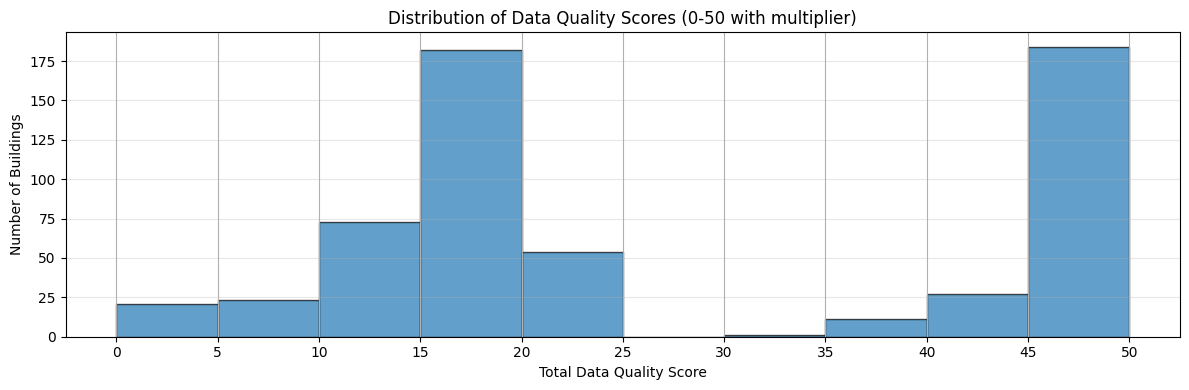


EXPORTING DATA QUALITY FILE
✅ Exported data quality report to output/data_quality_report.csv
   Total buildings: 576
   Columns: 25

📊 Sample: Top 5 lowest scoring buildings


,Building ID,Project ID,Project Name,BIN,BBL,Borough,Number,Street,earliest_dob_date,fully_permitted_date,...,count_new_building_dobnow_i1_matched,score_co_completion_alignment,score_nb_filing_count,score_bin_match,score_co_start_date_alignment,score_fully_permitted_timing,multiplier,total_data_quality_score,score_category,raw_score_sum
315,989393,64406,1184 RIVER AVE,NaN,NaN,Bronx,1160,RIVER AVENUE,2003-09-11,2014-08-12,...,0,0,0,0,0,0,0.5,0.0,0-15 (Poor),0
358,983133,64885,ROCKAWAY VILLAGE PHASE 1 (RITA STARK SITE),NaN,NaN,Queens,20-02,MOTT AVENUE,2003-09-11,2014-08-12,...,0,0,0,0,0,0,0.5,0.0,0-15 (Poor),0
529,996855,70488,ENNIS FRANCIS III- MIXED INCOME,NaN,NaN,Manhattan,202,WEST 124 STREET,2003-09-11,2014-08-12,...,0,0,0,0,0,0,0.5,0.0,0-15 (Poor),0
439,991371,67898,XENOLITH. 1810 WATSON AVENUE.SOTOMAYOR,2102921,2037300001,Bronx,1810,WATSON AVENUE,NaT,NaT,...,0,0,0,0,0,0,0.5,0.0,0-15 (Poor),0
378,927561,65315,BED STUY CENTRAL AND NORTH PHASE I,NaN,NaN,Brooklyn,697A,JEFFERSON AVENUE,2003-09-11,2014-08-12,...,0,0,0,0,0,0,0.5,0.0,0-15 (Poor),0



📊 Sample: Top 5 highest scoring buildings


,Building ID,Project ID,Project Name,BIN,BBL,Borough,Number,Street,earliest_dob_date,fully_permitted_date,...,count_new_building_dobnow_i1_matched,score_co_completion_alignment,score_nb_filing_count,score_bin_match,score_co_start_date_alignment,score_fully_permitted_timing,multiplier,total_data_quality_score,score_category,raw_score_sum
450,996485,68160,O+O. 1611 & 1701 PURDY STREET. PARKCHESTER GAR...,2033976,2039430199,Bronx,1701,PURDY STREET,2019-06-27,2021-04-13,...,0,10,10,10,10,10,1.0,50.0,41-50 (Excellent),50
451,989008,68210,COMUNILIFE. 3395-3401 THIRD AVENUE,2001305,2023710052,Bronx,3401,3 AVENUE,2019-04-29,2020-05-27,...,0,10,10,10,10,10,1.0,50.0,41-50 (Excellent),50
219,966928,59032,Atlantic Yards B3,3418421,3011187501,Brooklyn,38,6 AVENUE,2015-02-12,2015-09-21,...,0,10,10,10,10,10,1.0,50.0,41-50 (Excellent),50
221,969140,59495,2700 JEROME AVENUE,2129358,2033177501,Bronx,2700,JEROME AVENUE,2015-12-30,2017-05-15,...,0,10,10,10,10,10,1.0,50.0,41-50 (Excellent),50
183,972215,55249,ST. BARNABAS WELLNESS CARE & AFFORDABLE HOUSING,2127259,2030487501,Bronx,4439,3 AVENUE,2015-09-17,2016-09-13,...,0,10,10,10,10,10,1.0,50.0,41-50 (Excellent),50



TRACKING RUN HISTORY
✅ Run history saved to output/data_quality_run_history.csv
   Total runs tracked: 15

COMPARISON TO PREVIOUS RUN

📅 Previous run: 2025-12-04 11:54:40
📅 Current run:  2025-12-04 12:01:16

📊 Key Metrics:
   Avg Score: 27.1 → 26.8 (-0.3) ⚠️  REGRESSED
   Median Score: 17.5 → 17.5 (0.0) ➖ No change
   % Excellent: 36.5% → 35.2% (-1.3%) ⚠️  REGRESSED
   % Good+: 38.7% → 38.7% (+0.0%) ➖ No change
   % Poor: 42.4% → 42.4% (-0.0%) ➖ No change

📊 Individual Score Averages:
   Score 1 (CO/Completion): 6.3 → 6.0 (-0.3) ⚠️  REGRESSED
   Score 2 (NB Filing Count): 8.3 → 8.4 (+0.0) ➖ No change
   Score 3 (BIN Match): 9.3 → 9.3 (+0.0) ➖ No change
   Score 4 (CO Timeline): 5.3 → 5.3 (-0.0) ➖ No change
   Score 5 (Permit Timing): 6.5 → 6.5 (+0.0) ➖ No change

📊 Coverage:
   Buildings w/ DOB Date: 558.0 → 558.0 (0.0) ➖ No change
   Buildings w/ CO Date: 322.0 → 322.0 (0.0) ➖ No change

➖ OVERALL: No significant change from previous run.

📈 Recent Run History (last 5 runs):


,run_datetime,avg_score,pct_excellent,pct_good_or_better,pct_poor
10,2025-12-04 11:44:50,35.35,36.5,60.2,8.7
11,2025-12-04 11:46:36,26.90,36.5,38.7,39.8
12,2025-12-04 11:50:54,27.06,36.5,38.7,42.4
13,2025-12-04 11:54:40,27.06,36.5,38.7,42.4
14,2025-12-04 12:01:16,26.81,35.2,38.7,42.4



✅ Step 5 complete: Data quality scoring finished


In [21]:
print("\n" + "=" * 70)
print("STEP 5: DATA QUALITY SCORING")
print("=" * 70)

# Use the final dataframe with all dates
data_quality_df = hpd_multifamily_finance_new_construction_with_dob_date_df.copy()

# Ensure we have the necessary columns
print(f"\n📋 Starting with {len(data_quality_df)} buildings")
print(f"   Buildings with earliest_co_date: {data_quality_df['earliest_co_date'].notna().sum()}")
print(f"   Buildings with earliest_dob_date: {data_quality_df['earliest_dob_date'].notna().sum()}")

# Initialize score columns
data_quality_df['score_co_completion_alignment'] = 0
data_quality_df['score_nb_filing_count'] = 0
data_quality_df['score_bin_match'] = 0
data_quality_df['score_co_start_date_alignment'] = 0
data_quality_df['score_fully_permitted_timing'] = 0
# Note: total_data_quality_score will be overwritten with new logic later

# ======================================================================
# SCORE 1: CO Date vs Building Completion Date Alignment (0-10 points)
# ======================================================================
print("\n" + "=" * 70)
print("SCORE 1: CO DATE VS BUILDING COMPLETION DATE ALIGNMENT")
print("=" * 70)

# Identify the building completion date column
completion_date_col = None
for col in data_quality_df.columns:
    if 'building completion' in col.lower() and 'date' in col.lower():
        completion_date_col = col
        break

if completion_date_col:
    print(f"✅ Found completion date column: {completion_date_col}")
    
    # Convert to datetime
    data_quality_df[completion_date_col] = pd.to_datetime(data_quality_df[completion_date_col], errors='coerce')
    data_quality_df['earliest_co_date'] = pd.to_datetime(data_quality_df['earliest_co_date'], errors='coerce')
    
    # Calculate alignment score
    both_empty_count = 0
    for idx, row in data_quality_df.iterrows():
        co_is_null = pd.isna(row['earliest_co_date'])
        completion_is_null = pd.isna(row[completion_date_col])
        
        if co_is_null and completion_is_null:
            # Both dates are empty - give full score (no data to penalize)
            score = 10
            both_empty_count += 1
        elif pd.notna(row['earliest_co_date']) and pd.notna(row[completion_date_col]):
            co_date = row['earliest_co_date']
            completion_date = row[completion_date_col]
            
            # Calculate difference in months
            diff_days = abs((co_date - completion_date).days)
            diff_months = diff_days / 30.44  # Average days per month
            
            # Score calculation
            if diff_months == 0 or diff_days <= 15:  # Exact match or within 15 days
                score = 10
            elif diff_months <= 1:  # Within 1 month
                score = 8
            else:
                # Subtract 2 points for each month difference
                score = min(1,max(0, 10 - (int(diff_months) * 2)))
        else:
            # Only one date is missing - can't verify alignment
            score = 0
        
        data_quality_df.loc[idx, 'score_co_completion_alignment'] = score
    
    buildings_scored = (data_quality_df['score_co_completion_alignment'] > 0).sum()
    avg_score = data_quality_df['score_co_completion_alignment'].mean()
    print(f"   Buildings scored: {buildings_scored}")
    print(f"   Buildings with both dates empty (10/10): {both_empty_count}")
    print(f"   Average score: {avg_score:.2f}/10")
else:
    print("⚠️  No building completion date column found - skipping CO alignment score")

# ======================================================================
# SCORE 2: Number of NB Filings (0-10 points)
# ======================================================================
print("\n" + "=" * 70)
print("SCORE 2: NUMBER OF NB/NEW BUILDING FILINGS")
print("=" * 70)

# Check if count columns exist
if 'count_nb_bisweb_01_matched' in data_quality_df.columns and 'count_new_building_dobnow_i1_matched' in data_quality_df.columns:
    # Calculate total NB filings (BISWEB + DOBNOW)
    data_quality_df['total_nb_filings'] = (
        data_quality_df['count_nb_bisweb_01_matched'] + 
        data_quality_df['count_new_building_dobnow_i1_matched']
    )
    
    # Score: 10 if exactly 1 filing, 0 if >1
    for idx, row in data_quality_df.iterrows():
        total_filings = row['total_nb_filings']
        if total_filings == 1:
            score = 10
        elif total_filings > 1:
            score = 5
        else:
            # No filings - assign 0 (building has no DOB match)
            score = 0
        
        data_quality_df.loc[idx, 'score_nb_filing_count'] = score
    
    # Statistics
    buildings_with_1_filing = (data_quality_df['total_nb_filings'] == 1).sum()
    buildings_with_multiple_filings = (data_quality_df['total_nb_filings'] > 1).sum()
    buildings_with_no_filings = (data_quality_df['total_nb_filings'] == 0).sum()
    avg_score = data_quality_df['score_nb_filing_count'].mean()
    
    print(f"   Buildings with exactly 1 NB filing: {buildings_with_1_filing} (score: 10/10)")
    print(f"   Buildings with >1 NB filings: {buildings_with_multiple_filings} (score: 0/10)")
    print(f"   Buildings with 0 NB filings: {buildings_with_no_filings} (score: 0/10)")
    print(f"   Average score: {avg_score:.2f}/10")
else:
    print("⚠️  Count columns not found - skipping NB filing count score")

# ======================================================================
# SCORE 3: BIN Match with DOB NB Application (0-10 points)
# ======================================================================
print("\n" + "=" * 70)
print("SCORE 3: BIN MATCH WITH DOB NB APPLICATION")
print("=" * 70)

# Check if building has at least one NB filing match
if 'total_nb_filings' in data_quality_df.columns:
    for idx, row in data_quality_df.iterrows():
        if row['total_nb_filings'] > 0:
            score = 10
        else:
            score = 0
        
        data_quality_df.loc[idx, 'score_bin_match'] = score
    
    buildings_matched = (data_quality_df['score_bin_match'] > 0).sum()
    buildings_unmatched = (data_quality_df['score_bin_match'] == 0).sum()
    avg_score = data_quality_df['score_bin_match'].mean()
    
    print(f"   Buildings with DOB NB match: {buildings_matched} (score: 10/10)")
    print(f"   Buildings without DOB NB match: {buildings_unmatched} (score: 0/10)")
    print(f"   Average score: {avg_score:.2f}/10")
else:
    print("⚠️  No NB filing data available - skipping BIN match score")

# ======================================================================
# SCORE 4: CO Date vs Project Start Date (0-10 points)
# ======================================================================
print("\n" + "=" * 70)
print("SCORE 4: CO DATE VS PROJECT START DATE (TIMELINE)")
print("=" * 70)

# Find Project Start Date column
project_start_col = None
for col in data_quality_df.columns:
    if 'project' in col.lower() and 'start' in col.lower() and 'date' in col.lower():
        project_start_col = col
        break

if project_start_col:
    print(f"✅ Found project start date column: {project_start_col}")
    
    # Convert to datetime
    data_quality_df[project_start_col] = pd.to_datetime(data_quality_df[project_start_col], errors='coerce')
    data_quality_df['earliest_co_date'] = pd.to_datetime(data_quality_df['earliest_co_date'], errors='coerce')
    
    # Calculate CO timing score
    for idx, row in data_quality_df.iterrows():
        if pd.notna(row['earliest_co_date']) and pd.notna(row[project_start_col]):
            co_date = row['earliest_co_date']
            start_date = row[project_start_col]
            
            # Calculate difference in years
            diff_days = (co_date - start_date).days
            diff_years = diff_days / 365.25
            
            # Score calculation based on whether CO came within reasonable timeframe
            if diff_years < 0:
                # CO before project start - possible data error
                score = 0
            elif diff_years <= 4:
                # CO within 4 years of start - excellent
                score = 10
            elif diff_years <= 5:
                # CO within 5 years - acceptable
                score = 5
            else:
                # CO more than 5 years after start - concerning delay
                score = 0
            
            data_quality_df.loc[idx, 'score_co_start_date_alignment'] = score
    
    buildings_scored = (data_quality_df['score_co_start_date_alignment'] > 0).sum()
    avg_score = data_quality_df['score_co_start_date_alignment'].mean()
    print(f"   Buildings scored: {buildings_scored}")
    print(f"   Average score: {avg_score:.2f}/10")
    
    # Distribution
    co_within_4yrs = (data_quality_df['score_co_start_date_alignment'] == 10).sum()
    co_within_5yrs = (data_quality_df['score_co_start_date_alignment'] == 5).sum()
    co_over_5yrs = ((data_quality_df['score_co_start_date_alignment'] == 0) & 
                     data_quality_df['earliest_co_date'].notna() & 
                     data_quality_df[project_start_col].notna()).sum()
    print(f"   CO within 4 years: {co_within_4yrs} (10 points)")
    print(f"   CO within 5 years: {co_within_5yrs} (5 points)")
    print(f"   CO over 5 years: {co_over_5yrs} (0 points)")
else:
    print("⚠️  No project start date column found - skipping CO timeline score")

# ======================================================================
# SCORE 5: Fully Permitted Date vs Project Start Date (0-10 points)
# ======================================================================
print("\n" + "=" * 70)
print("SCORE 5: FULLY PERMITTED DATE VS PROJECT START DATE (TIMING)")
print("=" * 70)

# Check if fully_permitted_date exists
if 'fully_permitted_date' in data_quality_df.columns and project_start_col:
    print(f"✅ Found fully_permitted_date column")
    
    # Convert to datetime
    data_quality_df['fully_permitted_date'] = pd.to_datetime(data_quality_df['fully_permitted_date'], errors='coerce')
    data_quality_df[project_start_col] = pd.to_datetime(data_quality_df[project_start_col], errors='coerce')
    
    # Calculate fully permitted timing score (based on absolute difference)
    for idx, row in data_quality_df.iterrows():
        if pd.notna(row['fully_permitted_date']) and pd.notna(row[project_start_col]):
            permitted_date = row['fully_permitted_date']
            start_date = row[project_start_col]
            
            # Calculate absolute difference in months
            diff_days = abs((permitted_date - start_date).days)
            diff_months = diff_days / 30.44
            
            # Score calculation based on permitting speed (absolute diff)
            if diff_months <= 6:
                # Permitted within 6 months (in either direction) - excellent
                score = 10
            elif diff_months <= 12:
                # Permitted within 12 months (in either direction) - acceptable
                score = 5
            else:
                # Permitted more than 12 months apart - slow/outlier
                score = 0
            
            data_quality_df.loc[idx, 'score_fully_permitted_timing'] = score
    
    buildings_scored = (data_quality_df['score_fully_permitted_timing'] > 0).sum()
    avg_score = data_quality_df['score_fully_permitted_timing'].mean()
    print(f"   Buildings scored: {buildings_scored}")
    print(f"   Average score: {avg_score:.2f}/10")
    
    # Distribution
    perm_within_6mo = (data_quality_df['score_fully_permitted_timing'] == 10).sum()
    perm_within_12mo = (data_quality_df['score_fully_permitted_timing'] == 5).sum()
    perm_over_12mo = ((data_quality_df['score_fully_permitted_timing'] == 0) & 
                       data_quality_df['fully_permitted_date'].notna() & 
                       data_quality_df[project_start_col].notna()).sum()
    print(f"   Permitted within 6 months: {perm_within_6mo} (10 points)")
    print(f"   Permitted within 12 months: {perm_within_12mo} (5 points)")
    print(f"   Permitted after 12 months: {perm_over_12mo} (0 points)")
else:
    if 'fully_permitted_date' not in data_quality_df.columns:
        print("⚠️  No fully_permitted_date column found - skipping permitting timing score")
    elif not project_start_col:
        print("⚠️  No project start date column found - skipping permitting timing score")

# ======================================================================
# CALCULATE TOTAL SCORE WITH MULTIPLIER
# ======================================================================
print("\n" + "=" * 70)
print("TOTAL DATA QUALITY SCORE WITH MULTIPLIER")
print("=" * 70)

component_score_cols = [
    'score_co_completion_alignment',
    'score_nb_filing_count',
    'score_bin_match',
    'score_co_start_date_alignment',
    'score_fully_permitted_timing'
]

# Add multiplier column: if any (component score == 0), multiplier = 0.5, else 1.0
def compute_multiplier(row):
    for col in component_score_cols:
        if col in row and row[col] == 0:
            return 0.5
    return 1.0

data_quality_df['multiplier'] = data_quality_df.apply(compute_multiplier, axis=1)

# Compute total (raw) score and total_data_quality_score as (sum of individual scores) * multiplier
data_quality_df['raw_score_sum'] = data_quality_df[component_score_cols].sum(axis=1)
data_quality_df['total_data_quality_score'] = data_quality_df['raw_score_sum'] * data_quality_df['multiplier']

avg_total_score = data_quality_df['total_data_quality_score'].mean()
max_total_score = data_quality_df['total_data_quality_score'].max()
min_total_score = data_quality_df['total_data_quality_score'].min()

print(f"   Average total score: {avg_total_score:.2f}/50")
print(f"   Max score: {max_total_score:.0f}/50")
print(f"   Min score: {min_total_score:.0f}/50")

# Score distribution by category (maintain the same bins for 50-point full scale)
print("\n📊 Score Distribution by Category:")
score_bins = [0, 15, 30, 40, 50]
score_labels = ['0-15 (Poor)', '16-30 (Fair)', '31-40 (Good)', '41-50 (Excellent)']
data_quality_df['score_category'] = pd.cut(
    data_quality_df['total_data_quality_score'], 
    bins=score_bins, 
    labels=score_labels,
    include_lowest=True
)
print(data_quality_df['score_category'].value_counts().sort_index())

# Detailed score distribution (every score value)
print("\n📊 Detailed Score Distribution (count per score):")
score_dist = data_quality_df['total_data_quality_score'].value_counts().sort_index()
print(score_dist.to_string())

# Percentiles
print("\n📊 Score Percentiles:")
percentiles = data_quality_df['total_data_quality_score'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
for pct, val in percentiles.items():
    print(f"   {int(pct*100)}th percentile: {val:.0f}")

# Histogram visualization
print("\n📊 Score Histogram:")
fig, ax = plt.subplots(figsize=(12, 4))
data_quality_df['total_data_quality_score'].hist(bins=range(0, 52, 5), ax=ax, edgecolor='black', alpha=0.7)
ax.set_xlabel('Total Data Quality Score')
ax.set_ylabel('Number of Buildings')
ax.set_title('Distribution of Data Quality Scores (0-50 with multiplier)')
ax.set_xticks(range(0, 55, 5))
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ======================================================================
# EXPORT DATA QUALITY FILE
# ======================================================================
print("\n" + "=" * 70)
print("EXPORTING DATA QUALITY FILE")
print("=" * 70)

# Select relevant columns for data quality report
quality_report_cols = [
    'Building ID', 'Project ID', 'Project Name', 
    'BIN', 'BBL', 'Borough', 'Number', 'Street',
    'earliest_dob_date', 'fully_permitted_date', 'earliest_co_date'
]

# Add completion date column if it exists
if completion_date_col:
    quality_report_cols.append(completion_date_col)

# Add project start date column if it exists
if project_start_col:
    quality_report_cols.append(project_start_col)

# Add count columns
quality_report_cols.extend([
    'total_nb_filings',
    'count_nb_bisweb_01_matched',
    'count_new_building_dobnow_i1_matched'
])

# Add score columns and the new multiplier info
quality_report_cols.extend([
    'score_co_completion_alignment',
    'score_nb_filing_count',
    'score_bin_match',
    'score_co_start_date_alignment',
    'score_fully_permitted_timing',
    'multiplier',
    'total_data_quality_score',
    'score_category'
])

# Optionally, add raw_score_sum for reference
if 'raw_score_sum' in data_quality_df.columns:
    quality_report_cols.append('raw_score_sum')

# Filter to only existing columns
quality_report_cols = [col for col in quality_report_cols if col in data_quality_df.columns]

data_quality_report_df = data_quality_df[quality_report_cols].copy()

# Sort by total score (ascending)
data_quality_report_df = data_quality_report_df.sort_values('total_data_quality_score', ascending=True)

# Export
output_path = 'output/data_quality_report.csv'
os.makedirs('output', exist_ok=True)
data_quality_report_df.to_csv(output_path, index=False)

print(f"✅ Exported data quality report to {output_path}")
print(f"   Total buildings: {len(data_quality_report_df)}")
print(f"   Columns: {len(data_quality_report_df.columns)}")

# Display sample of high and low scoring buildings
print("\n📊 Sample: Top 5 lowest scoring buildings")
display(data_quality_report_df.head(5))

print("\n📊 Sample: Top 5 highest scoring buildings")
display(data_quality_report_df.tail(5))

# ======================================================================
# TRACK RUN HISTORY
# ======================================================================
print("\n" + "=" * 70)
print("TRACKING RUN HISTORY")
print("=" * 70)

from datetime import datetime
import pytz

# Get current time in NYC timezone
nyc_tz = pytz.timezone('America/New_York')
run_datetime = datetime.now(nyc_tz).strftime('%Y-%m-%d %H:%M:%S')

# Calculate metrics for this run
total_buildings = len(data_quality_df)
avg_score = data_quality_df['total_data_quality_score'].mean()
median_score = data_quality_df['total_data_quality_score'].median()
std_score = data_quality_df['total_data_quality_score'].std()

# Score category counts
poor_count = (data_quality_df['score_category'] == '0-15 (Poor)').sum()
fair_count = (data_quality_df['score_category'] == '16-30 (Fair)').sum()
good_count = (data_quality_df['score_category'] == '31-40 (Good)').sum()
excellent_count = (data_quality_df['score_category'] == '41-50 (Excellent)').sum()

# Percentages
pct_poor = (poor_count / total_buildings) * 100
pct_fair = (fair_count / total_buildings) * 100
pct_good = (good_count / total_buildings) * 100
pct_excellent = (excellent_count / total_buildings) * 100
pct_good_or_better = pct_good + pct_excellent

# Individual score averages
avg_score_1 = data_quality_df['score_co_completion_alignment'].mean()
avg_score_2 = data_quality_df['score_nb_filing_count'].mean()
avg_score_3 = data_quality_df['score_bin_match'].mean()
avg_score_4 = data_quality_df['score_co_start_date_alignment'].mean()
avg_score_5 = data_quality_df['score_fully_permitted_timing'].mean()

# Coverage metrics
buildings_with_dob_date = data_quality_df['earliest_dob_date'].notna().sum()
buildings_with_co_date = data_quality_df['earliest_co_date'].notna().sum()

# Create run record
run_record = {
    'run_datetime': run_datetime,
    'total_buildings': total_buildings,
    'avg_score': round(avg_score, 2),
    'median_score': round(median_score, 2),
    'std_score': round(std_score, 2),
    'poor_count': poor_count,
    'fair_count': fair_count,
    'good_count': good_count,
    'excellent_count': excellent_count,
    'pct_poor': round(pct_poor, 1),
    'pct_fair': round(pct_fair, 1),
    'pct_good': round(pct_good, 1),
    'pct_excellent': round(pct_excellent, 1),
    'pct_good_or_better': round(pct_good_or_better, 1),
    'avg_score_1_co_completion': round(avg_score_1, 2),
    'avg_score_2_nb_filing_count': round(avg_score_2, 2),
    'avg_score_3_bin_match': round(avg_score_3, 2),
    'avg_score_4_co_timeline': round(avg_score_4, 2),
    'avg_score_5_permitted_timing': round(avg_score_5, 2),
    'buildings_with_dob_date': buildings_with_dob_date,
    'buildings_with_co_date': buildings_with_co_date
}

# History file path
history_file = 'output/data_quality_run_history.csv'

# Load existing history or create new
if os.path.exists(history_file):
    history_df = pd.read_csv(history_file)
    previous_run = history_df.iloc[-1] if len(history_df) > 0 else None
else:
    history_df = pd.DataFrame()
    previous_run = None

# Append new run
new_run_df = pd.DataFrame([run_record])
history_df = pd.concat([history_df, new_run_df], ignore_index=True)

# Save history
history_df.to_csv(history_file, index=False)
print(f"✅ Run history saved to {history_file}")
print(f"   Total runs tracked: {len(history_df)}")

# Compare to previous run
print("\n" + "=" * 70)
print("COMPARISON TO PREVIOUS RUN")
print("=" * 70)

if previous_run is not None:
    print(f"\n📅 Previous run: {previous_run['run_datetime']}")
    print(f"📅 Current run:  {run_datetime}")
    
    # Calculate changes
    def format_change(current, previous, metric_name, higher_is_better=True, is_pct=False):
        try:
            prev_val = float(previous)
            curr_val = float(current)
            diff = curr_val - prev_val
            
            # Use 0.05 threshold - anything that rounds to 0.0 in display (:.1f) is "No change"
            if abs(diff) < 0.05:
                status = "➖ No change"
            elif (diff > 0 and higher_is_better) or (diff < 0 and not higher_is_better):
                status = "✅ IMPROVED"
            else:
                status = "⚠️  REGRESSED"
            
            sign = "+" if diff > 0 else ""
            suffix = "%" if is_pct else ""
            return f"   {metric_name}: {prev_val:.1f}{suffix} → {curr_val:.1f}{suffix} ({sign}{diff:.1f}{suffix}) {status}"
        except:
            return f"   {metric_name}: Unable to compare"
    
    print("\n📊 Key Metrics:")
    print(format_change(avg_score, previous_run['avg_score'], "Avg Score", higher_is_better=True))
    print(format_change(median_score, previous_run['median_score'], "Median Score", higher_is_better=True))
    print(format_change(pct_excellent, previous_run['pct_excellent'], "% Excellent", higher_is_better=True, is_pct=True))
    print(format_change(pct_good_or_better, previous_run['pct_good_or_better'], "% Good+", higher_is_better=True, is_pct=True))
    print(format_change(pct_poor, previous_run['pct_poor'], "% Poor", higher_is_better=False, is_pct=True))
    
    print("\n📊 Individual Score Averages:")
    print(format_change(avg_score_1, previous_run['avg_score_1_co_completion'], "Score 1 (CO/Completion)", higher_is_better=True))
    print(format_change(avg_score_2, previous_run['avg_score_2_nb_filing_count'], "Score 2 (NB Filing Count)", higher_is_better=True))
    print(format_change(avg_score_3, previous_run['avg_score_3_bin_match'], "Score 3 (BIN Match)", higher_is_better=True))
    print(format_change(avg_score_4, previous_run['avg_score_4_co_timeline'], "Score 4 (CO Timeline)", higher_is_better=True))
    print(format_change(avg_score_5, previous_run['avg_score_5_permitted_timing'], "Score 5 (Permit Timing)", higher_is_better=True))
    
    print("\n📊 Coverage:")
    print(format_change(buildings_with_dob_date, previous_run['buildings_with_dob_date'], "Buildings w/ DOB Date", higher_is_better=True))
    print(format_change(buildings_with_co_date, previous_run['buildings_with_co_date'], "Buildings w/ CO Date", higher_is_better=True))
    
    # Overall assessment
    print("\n" + "=" * 70)
    avg_change = float(avg_score) - float(previous_run['avg_score'])
    if avg_change > 1:
        print("🎉 OVERALL: Significant improvement! Keep up the good work!")
    elif avg_change > 0:
        print("✅ OVERALL: Slight improvement. Moving in the right direction.")
    elif avg_change > -1:
        print("➖ OVERALL: No significant change from previous run.")
    else:
        print("⚠️  OVERALL: Quality metrics have declined. Review recent changes.")
else:
    print("\n📝 This is the first tracked run - no comparison available.")
    print("   Future runs will show improvement/regression metrics.")

# Show recent history
if len(history_df) > 1:
    print("\n📈 Recent Run History (last 5 runs):")
    display_cols = ['run_datetime', 'avg_score', 'pct_excellent', 'pct_good_or_better', 'pct_poor']
    display(history_df[display_cols].tail(5))

print("\n✅ Step 5 complete: Data quality scoring finished")
